# Get NWP Candidates - Transformer

Notebook for selecting NWP candidates from a preprocessed transcript based on transformer accuracy and entropy. For a given transcript, we go through candidate words and evaluate the following out of a given transformer:
- Prediction accuracy (binary/cosine similarity)
    - Cosine similarity is evaluated using GloVe to avoid circularity of transformers
- Entropy (both of a distribution and relative to previous prediction)

In [6]:
%load_ext autoreload
import os, sys, glob
import json
import re
import numpy as np
import pandas as pd

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')
sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/utils/gentle')

import gentle
from config import *
# from text_utils import get_pos_tags, get_lemma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set directories 

In [7]:
base_dir = '/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/'
stim_dir = os.path.join(base_dir, 'stimuli')
cache_dir = os.path.join('/dartfs/rc/lab/F/FinnLab/tommy/', 'models')

gentle_dir = os.path.join(stim_dir, 'gentle')

In [8]:
task = 'wheretheressmoke'
stim_preprocessed_fn = os.path.join(stim_dir, 'preprocessed', task, f'{task}_transcript-preprocessed.csv')
df_preproc = pd.read_csv(stim_preprocessed_fn)


In [9]:
words, counts = np.unique(df_preproc[df_preproc['NWP_Candidate']]['Word_Written'], return_counts=True)
most_common = words[np.argsort(counts)[::-1]]

counts_sorted = counts[np.argsort(counts)[::-1]]

Text(0.5, 1.0, 'Task wheretheressmoke - word repetitions ')

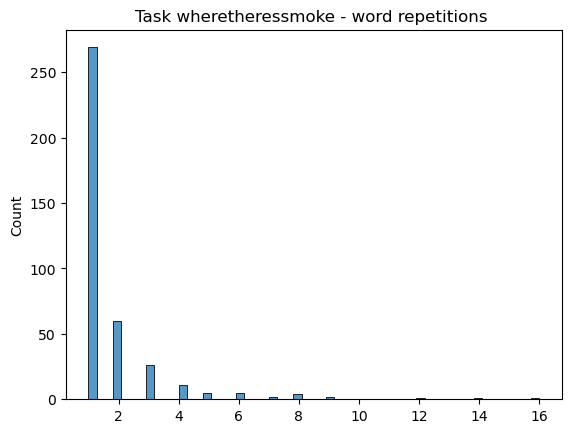

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.histplot(counts_sorted)
plt.title(f'Task {task} - word repetitions ')

# Load results for all models 

Then plot average accuracy by story

In [128]:
%autoreload 2
from natsort import natsorted
from nlp_utils import CLM_MODELS_DICT

def normalize(x):
    
    normed = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
    
    return normed

top_n = 5
window_size = 100

models = sorted(CLM_MODELS_DICT.keys())

models = ['bloom', 'gpt2', 'gpt2-xl', 'gpt-neo-x', 'llama2', 'mistral']

tasks = [os.path.basename(d) for d in sorted(glob.glob(os.path.join(STIM_DIR, 'preprocessed', '*')))]
tasks = [task for task in tasks if task not in ['example_trial', 'nwp_practice_trial']]

df_scores = pd.DataFrame(columns = ['model', 'avg_binary_accuracy', 'avg_continuous_accuracy'])

for model in models:
    for task in tasks:
        
        # load the preprocessed 
        stim_preprocessed_fn = os.path.join(STIM_DIR, 'preprocessed', task, f'{task}_transcript-preprocessed.csv')
        df_preproc = pd.read_csv(stim_preprocessed_fn)
        
        nwp_idxs = np.where(df_preproc['NWP_Candidate'])[0]
        
        # load the results
        model_dir = os.path.join(DERIVATIVES_DIR, 'model-predictions', task, model, f'window-size-{window_size}')
        results_fn = natsorted(glob.glob(os.path.join(model_dir, f'*top-{top_n}*')))[0]
        
        try:
            model_results = pd.read_csv(results_fn)
            
            
            
#             model_results['continuous_accuracy'] = normalize(model_results['continuous_accuracy'].to_numpy())
            
#             model_results = model_results.iloc[nwp_idxs]
        
            df_scores.loc[len(df_scores)] = {
                'model': model,
                'avg_binary_accuracy': np.nanmean(model_results['binary_accuracy']),
                'avg_continuous_accuracy': np.nanmean(model_results['continuous_accuracy'])
            }
        
        except:
            continue

In [576]:
def load_model_data(model_dir, model_name, task, top_n, window_size):
    
    model_dir = os.path.join(model_dir, task, model_name, f'window-size-{window_size}')
    results_fn = natsorted(glob.glob(os.path.join(model_dir, f'*top-{top_n}*')))[0]
    
    # load the data, remove nans
    model_results = pd.read_csv(results_fn)
    model_results['glove_continuous_accuracy'] = model_results['glove_continuous_accuracy'].apply(np.nan_to_num)
    model_results['word2vec_continuous_accuracy'] = model_results['word2vec_continuous_accuracy'].apply(np.nan_to_num)
#     model_results['continuous_accuracy'] = model_results['continuous_accuracy'].apply(np.nan_to_num)
    
    return model_results
    
def get_stim_candidate_idxs(task):
    
    preproc_fn = os.path.join(STIM_DIR, 'preprocessed', task, f'{task}_transcript-preprocessed.csv')
    df_preproc = pd.read_csv(preproc_fn)
    nwp_idxs = np.where(df_preproc['NWP_Candidate'])[0]
    
    return nwp_idxs

In [1194]:
# model_name = models[0]

top_ns = [1,5,10]
window_sizes = [25,50,100]

model_dir = os.path.join(DERIVATIVES_DIR, 'model-predictions')

models = sorted(CLM_MODELS_DICT.keys())
# models = ['bloom', 'gpt2', 'gpt2-xl', 'gpt-neo-x', 'llama2', 'mistral']

df_scores = pd.DataFrame(columns = ['model_name', 'task', 'window_size', 'top_n', 
                                    'avg_binary_accuracy', 'avg_glove_accuracy', 'avg_word2vec_accuracy'])

all_results = []

for model_name, task, window_size, top_n in product(models, tasks, window_sizes, top_ns):
    
    candidate_idxs = get_stim_candidate_idxs(task)
    
    # load model results and trim down to the candidate indices
    model_results = load_model_data(model_dir, model_name=model_name, task=task, top_n=top_n, window_size=window_size)
    
    try:
        model_results = model_results.iloc[candidate_idxs]
        
        df_scores.loc[len(df_scores)] = {
            'model_name': model_name,
            'task': task,
            'window_size': window_size,
            'top_n': top_n,
            'avg_binary_accuracy': np.nanmean(model_results['binary_accuracy']),
            'avg_glove_accuracy': np.nanmean(model_results['glove_continuous_accuracy']),
            'avg_word2vec_accuracy': np.nanmean(model_results['word2vec_continuous_accuracy'])
        }
        
        model_results[['model_name', 'task', 'top_n', 'window_size']] = [model_name, task, top_n, window_size]
        all_results.append(model_results)
    except:
        continue
        
all_results = pd.concat(all_results)

# all_results = all_results.groupby(['model_name', 'task', 'window_size', 'top_n'], as_index=False) \
#     .agg({'binary_accuracy': np.nanmean, 
#           'glove_continuous_accuracy': np.nanmean, 
#           'word2vec_continuous_accuracy': np.nanmean}) \
#     .rename(columns={'binary_accuracy': 'avg_binary_accuracy',
#             'glove_continuous_accuracy': 'avg_glove_accuracy',
#             'word2vec_continuous_accuracy': 'avg_word2vec_accuracy'})

## Plot dice coefficients of model accuracy

In [1104]:
def get_model_pairwise_similarity(all_results, result_type='binary_accuracy', metric='dice'):
    
    # for each task, examine model correlation matrix with each other
    df_results = []

    for i, ((task, window_size, top_n), df) in enumerate(all_results.groupby(['task', 'window_size', 'top_n'])):
        
        model_result = df.pivot(columns=['model_name'], values=[result_type]).droplevel(level=0, axis=1)
        model_names = model_result.columns
        
        # calculate dice coef
        similarity = 1 - cdist(model_result.T, model_result.T, metric=metric)

        pair_names = [f'pair{str(i).zfill(2)}-{pair[0]}-{pair[1]}' for i, pair in enumerate(product(model_names, model_names))]

        df = pd.DataFrame({
            'model_pair': pair_names,
            'task': task,
            'window_size': window_size,
            'top_n': top_n,
            metric: similarity.flatten()
        })

        df_results.append(df)
        
    df_results = pd.concat(df_results)
    
    avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \
        .agg({metric: np.nanmean}).reset_index(drop=True) 
    
    return avg_result

/tmp/ipykernel_36120/4220570683.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_accuracy = all_accuracy.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \


SystemExit: 0

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/asynchrony/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


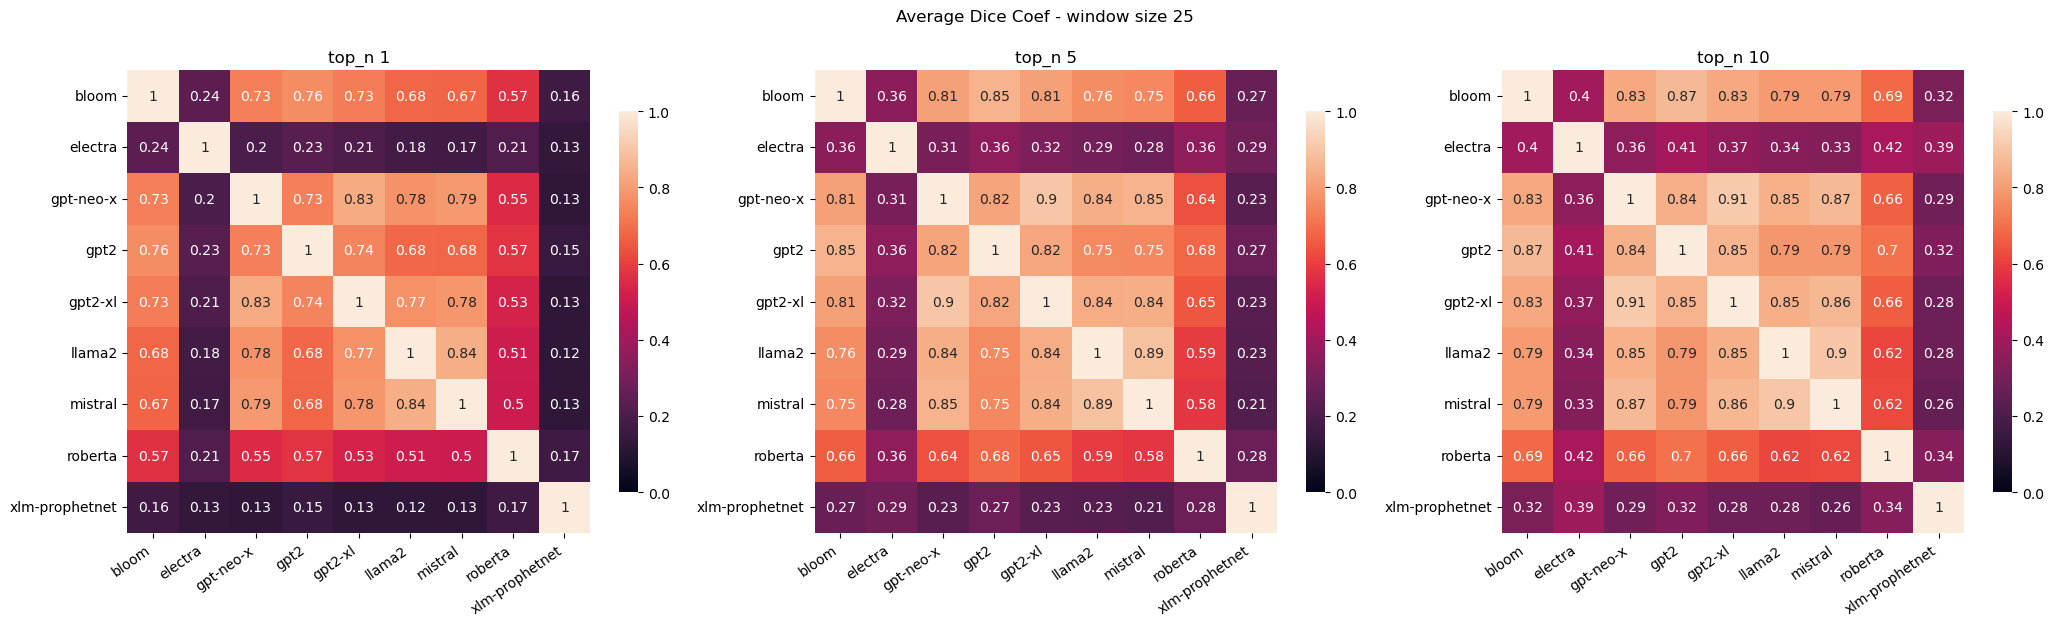

In [1081]:
avg_task_binary_corr = get_pairwise_accuracy(all_results, accuracy_type='binary_accuracy', metric='dice')

for window_size, df_window in avg_task_binary_corr.groupby(['window_size']):
    
    fig, axes = plt.subplots(1, len(window_sizes), figsize=(21, 7))
    axes = axes.flatten()
    
    for ax, (top_n, df) in zip(axes, df_window.groupby(['top_n'])):
    
        dice_sim_matrix = np.reshape(df['dice'], (n_models, n_models))

        sns.heatmap(dice_sim_matrix, annot=True, square=True, xticklabels=model_names, 
                         yticklabels=model_names, vmin=0, vmax=1, cbar_kws={"shrink": 0.6}, ax=ax)
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
        ax.title.set_text(f'top_n {top_n[0]}')
        
#         plt.tight_layout()
    plt.suptitle(f'Average Dice Coef - window size {window_size[0]}', y=0.9)
    plt.tight_layout()
    sys.exit(0)

## Plot pairwise correlations of average continuous accuracy

In [1153]:
def plot_model_similarity(all_results, groupvar, result_type, metric, filtervar=None):

    model_names = all_results['model_name'].unique().tolist()
    n_models = len(model_names)

    avg_results = get_model_pairwise_similarity(all_results, result_type=result_type, metric=metric)

    # chop down to the window size
    if filtervar:
        avg_results = avg_results[avg_results[filtervar[0]] == filtervar[1]]

    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    axes = axes.flatten()
    
    if metric == 'dice':
        vmin = 0
        vmax = 1
        center = 0
    elif metric == 'correlation':
        vmin = -1
        vmax = 1
        center = 0
        

    for ax, (group, df) in zip(axes, avg_results.groupby(groupvar)):

        # TLB --> SHOULD ENSURE ZTRANSFORM BEFORE AVERAGE
        df = df.groupby('model_pair').agg({metric: 'mean'})

        similarity_matrix = np.reshape(df[metric], (n_models,n_models))

        sns.heatmap(similarity_matrix, annot=True, square=True, xticklabels=model_names, 
                         yticklabels=model_names, cmap='RdBu_r', vmin=vmin, vmax=vmax, center=center, cbar_kws={"shrink": 0.6}, ax=ax)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
        ax.title.set_text(f'{groupvar}: {group}')

    return fig, axes

In [1198]:
all_results['glove_prediction_density']

1                                                  [[0.]]
2                                                  [[0.]]
3                                      [[1.11022302e-16]]
4                                                  [[0.]]
7                                                     NaN
                              ...                        
1818    [[0.         0.18485946 0.21677183 0.14884171 ...
1821    [[2.22044605e-16 2.11892733e-01 2.54792517e-01...
1823    [[0.         0.51263631 0.48447711 0.65485938 ...
1824    [[0.00000000e+00 4.53693691e-01 4.24671751e-01...
1826    [[1.11022302e-16 5.69374918e-01 5.50397593e-01...
Name: glove_prediction_density, Length: 631314, dtype: object

In [ ]:
fig, axes = plot_model_similarity(all_results, groupvar='top_n', filtervar=['window_size', window_size], 
                                  result_type='binary_accuracy', metric='dice')

plt.suptitle(f'Average Dice Coef - window size {window_size}', y=0.9)
plt.tight_layout()


/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \
/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \
/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current be

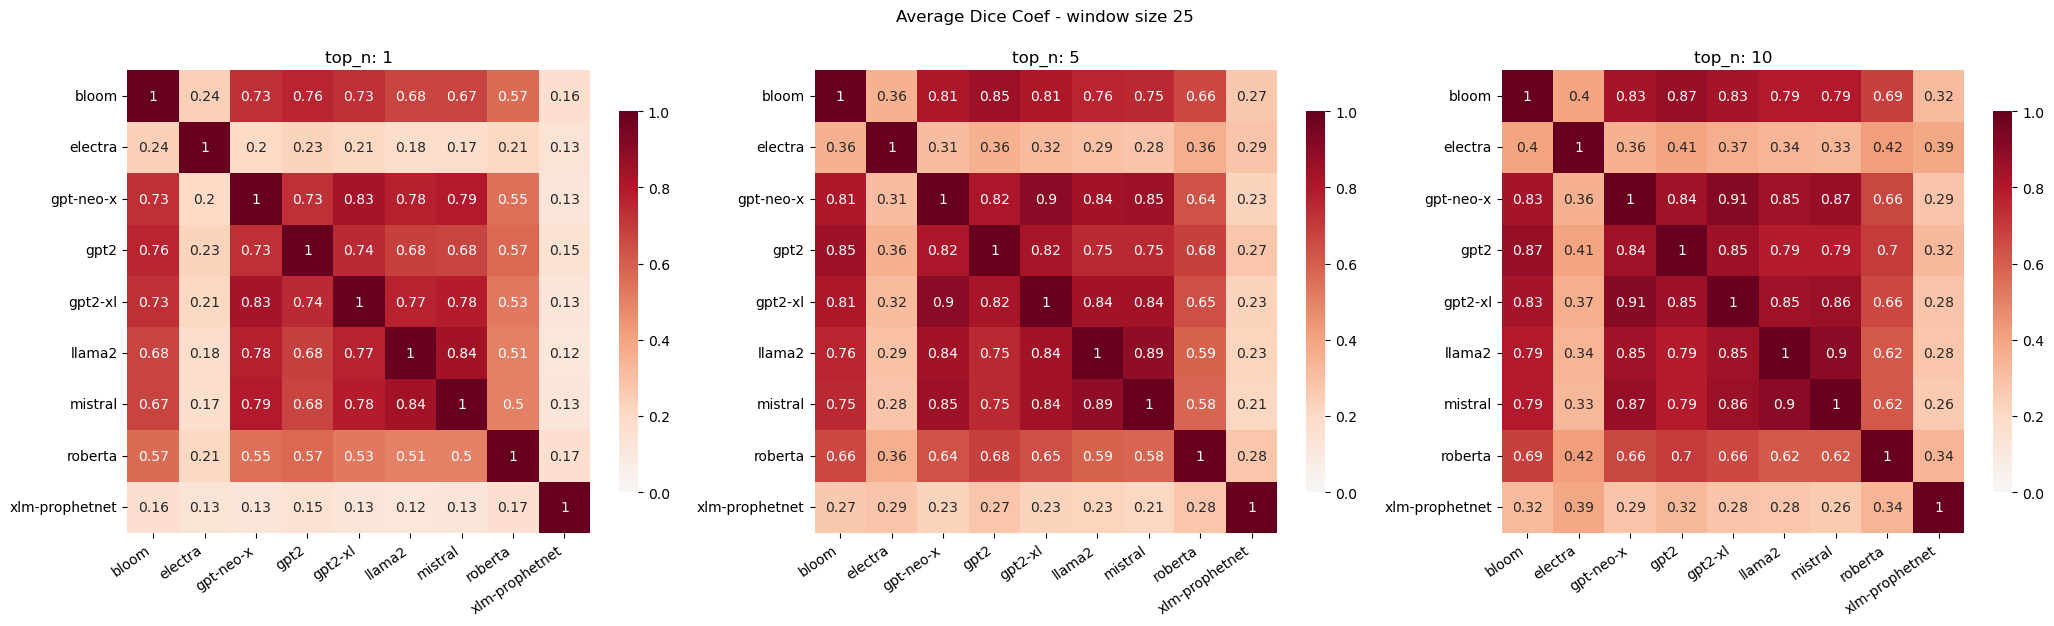

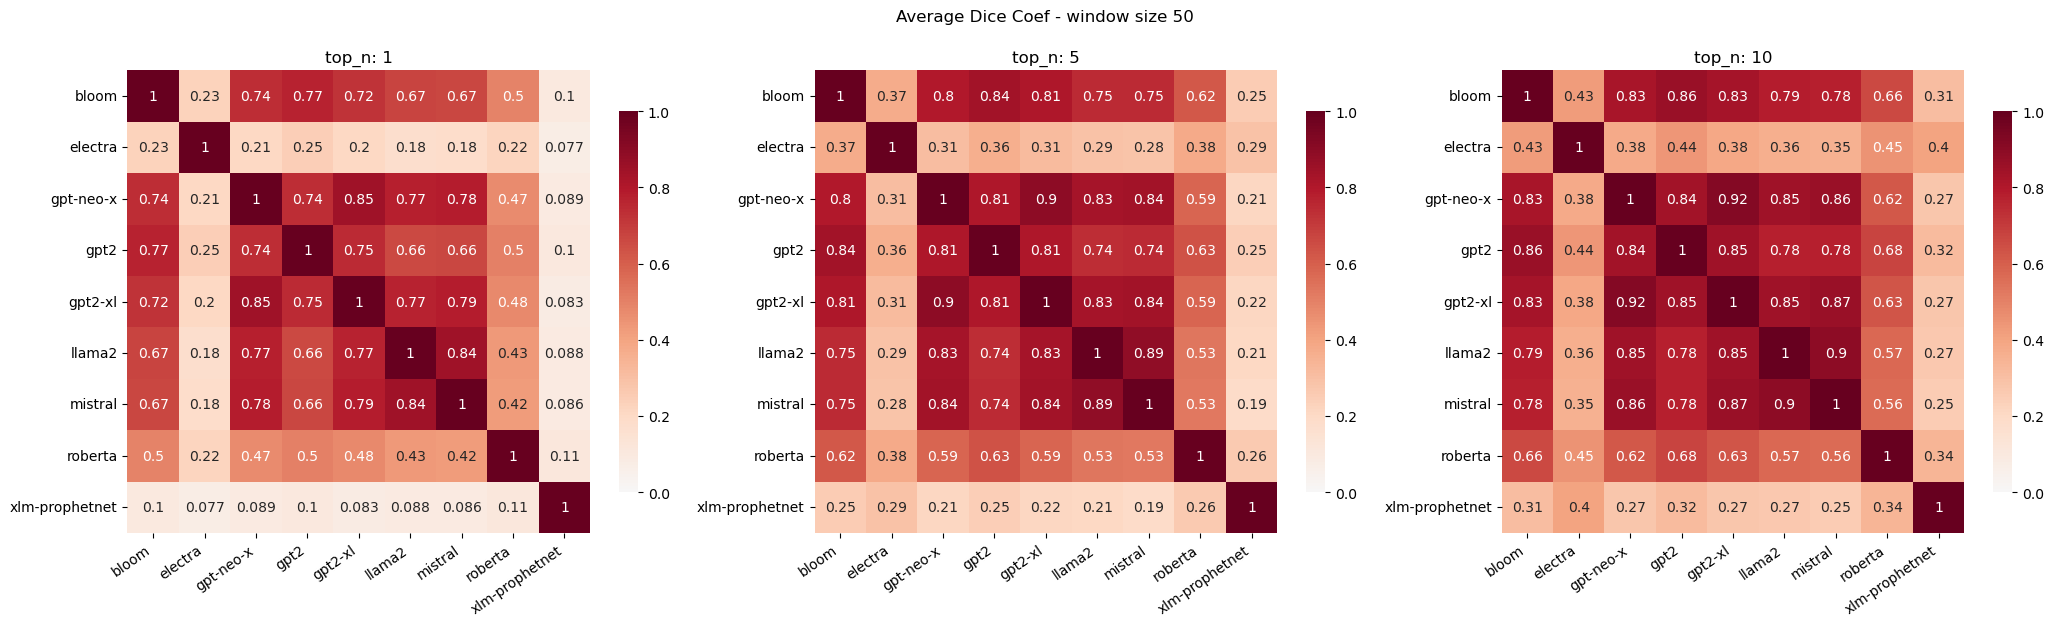

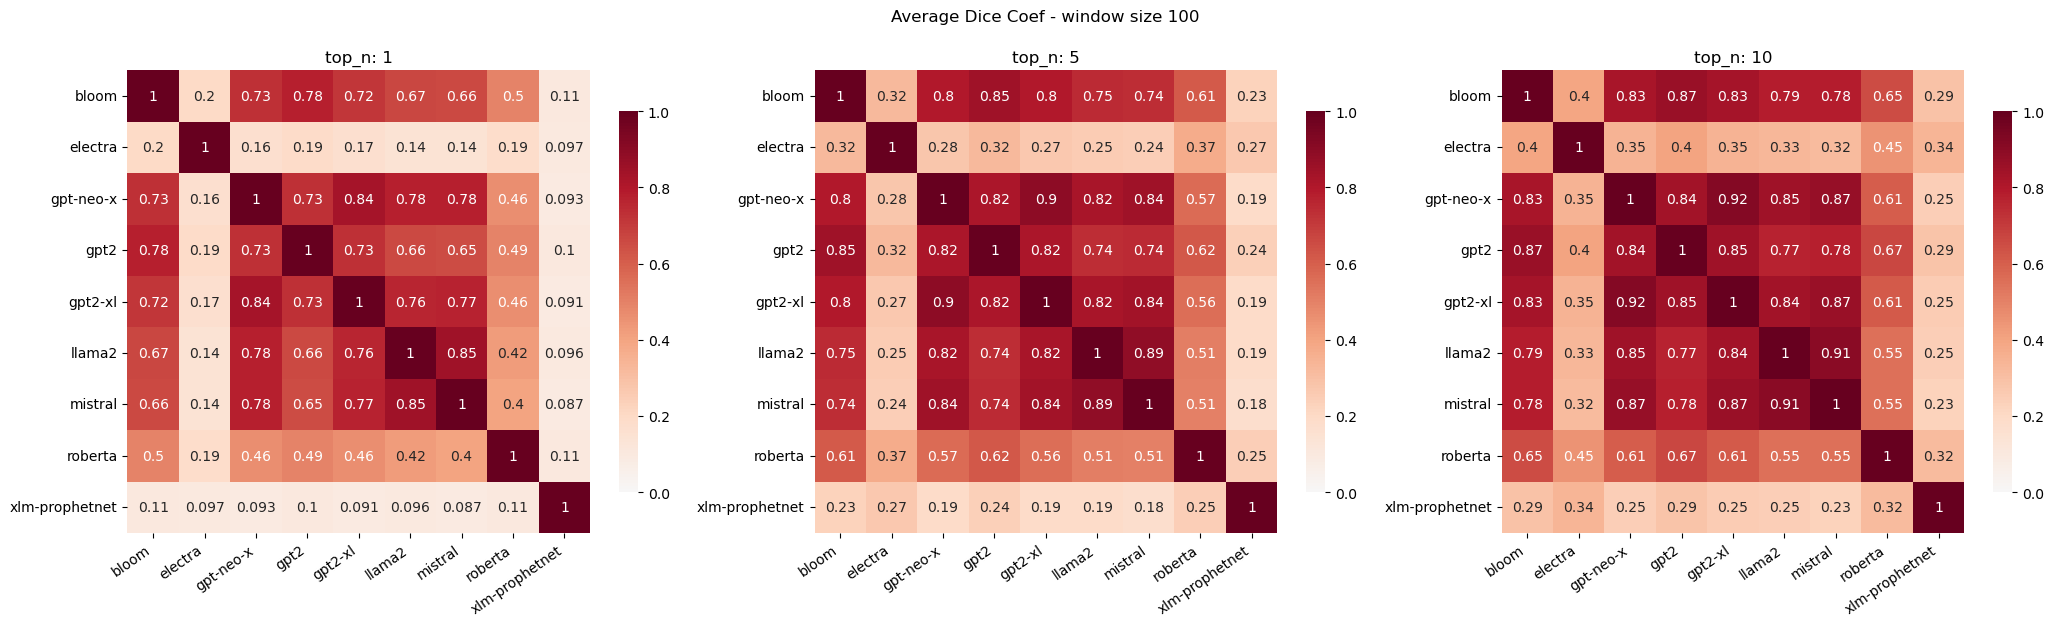

In [1154]:
for window_size in window_sizes:
    fig, axes = plot_model_similarity(all_results, groupvar='top_n', filtervar=['window_size', window_size], 
                                      result_type='binary_accuracy', metric='dice')
    
    plt.suptitle(f'Average Dice Coef - window size {window_size}', y=0.9)
    plt.tight_layout()



/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \
/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \
/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current be

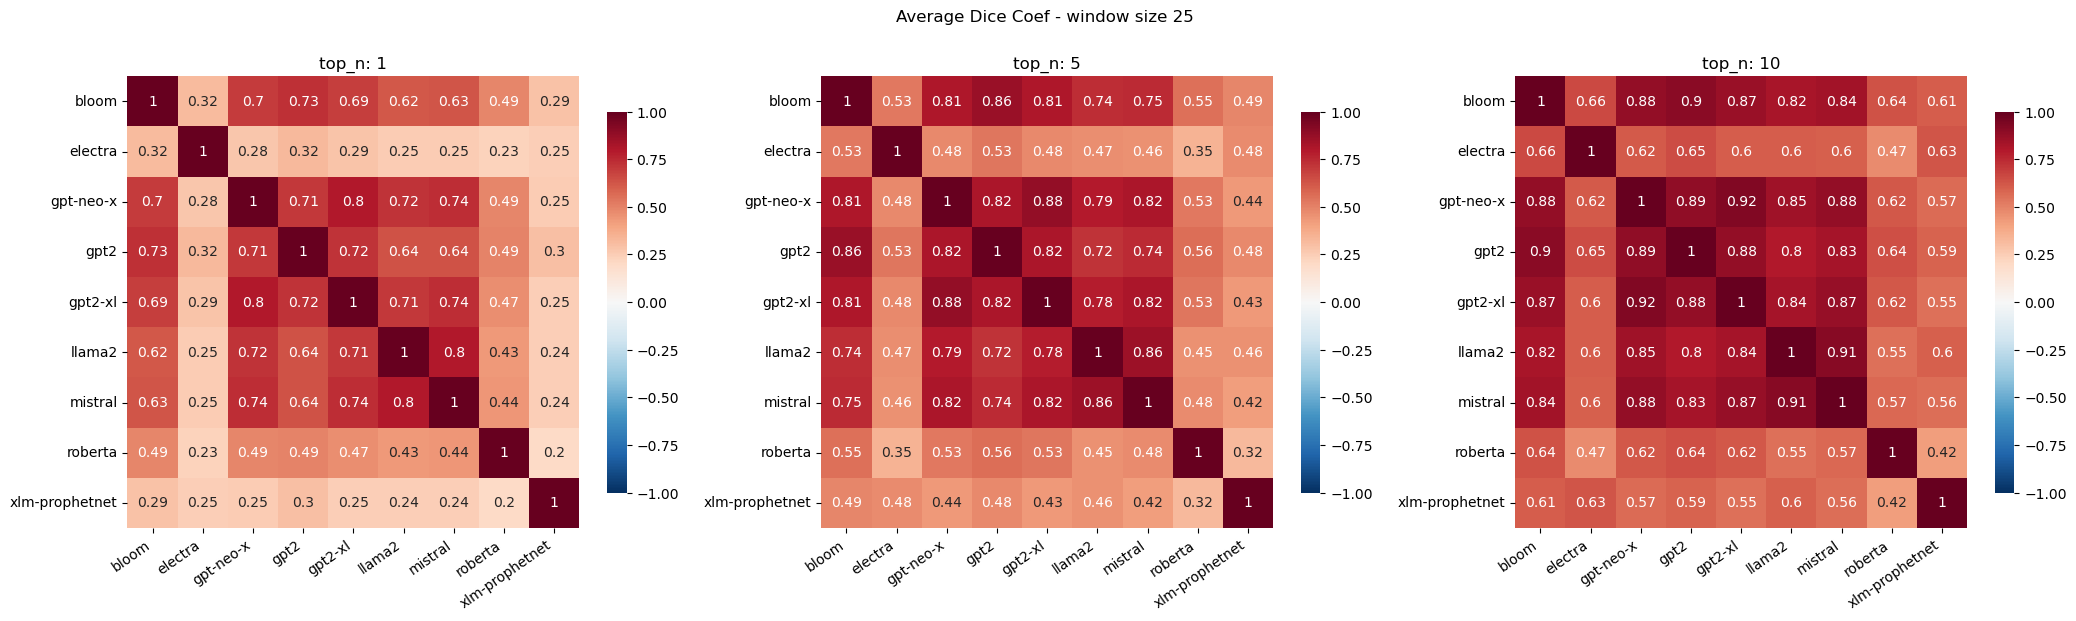

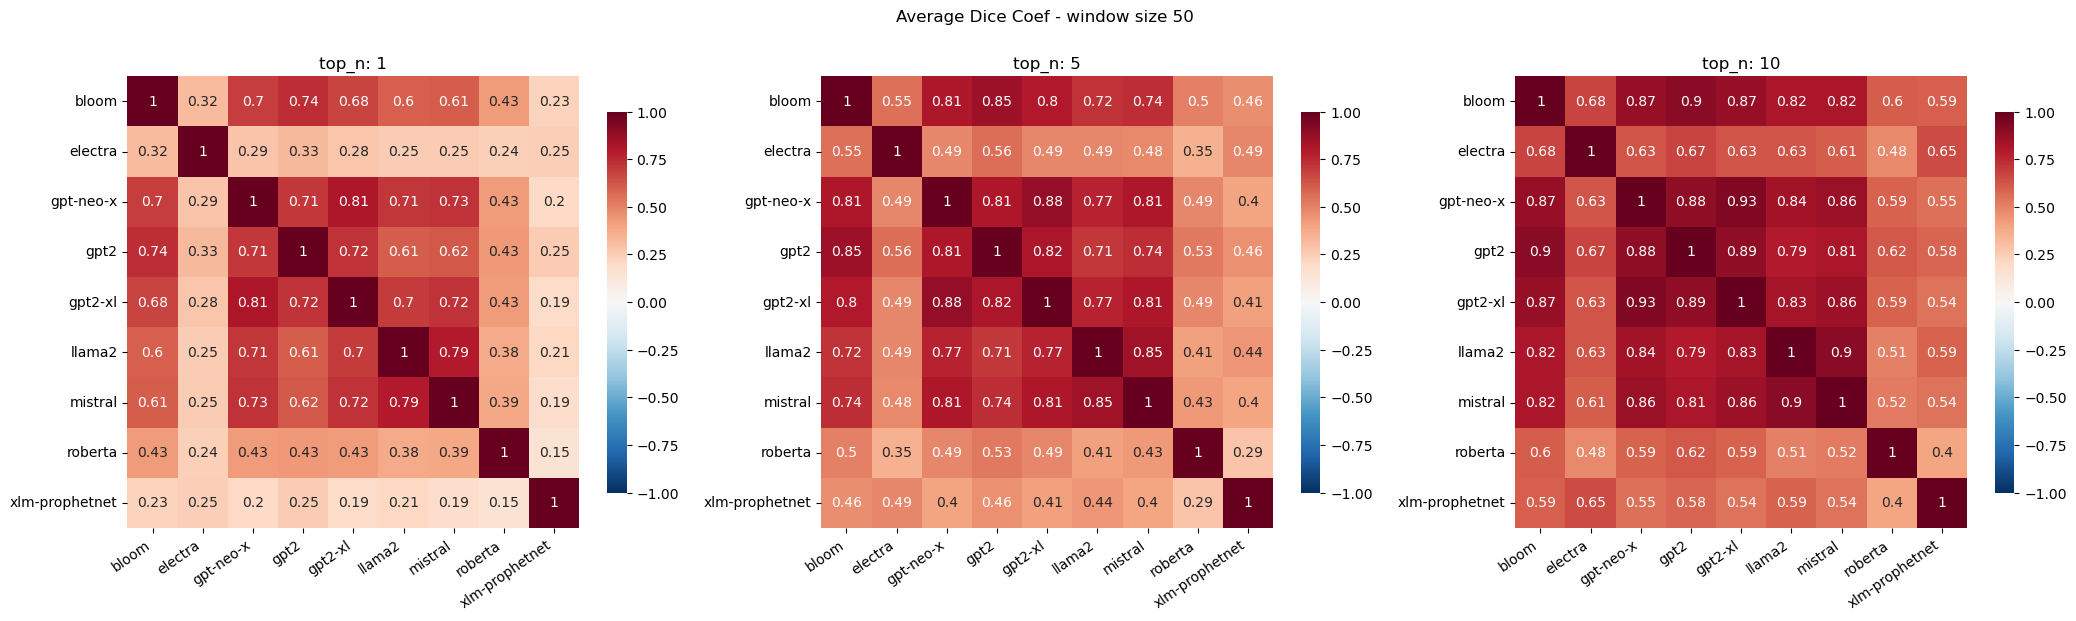

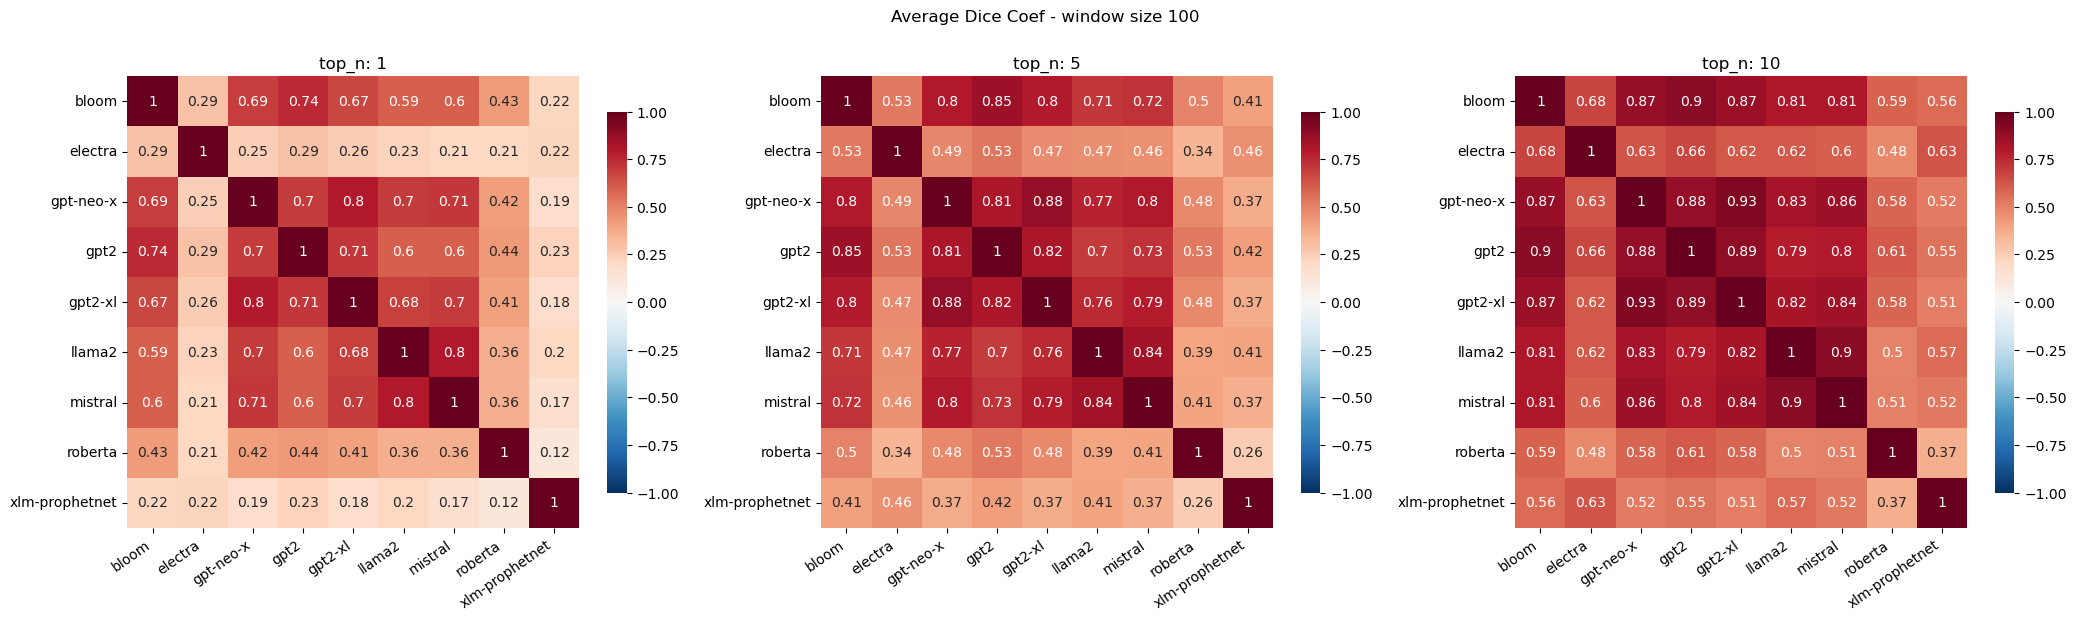

In [1156]:
for window_size in window_sizes:
    fig, axes = plot_model_similarity(all_results, groupvar='top_n', filtervar=['window_size', window_size], 
                                      result_type='word2vec_continuous_accuracy', metric='correlation')
    
    plt.suptitle(f'Average Dice Coef - window size {window_size}', y=0.9)
    plt.tight_layout()

In [1157]:

result_metrics = [
    ('binary_accuracy', 'dice'),
    ('glove_continuous_accuracy', 'correlation'),
    ('word2vec_continuous_accuracy', 'correlation'),
]


In [1160]:
list(product(result_metrics, window_sizes))[0]

(('binary_accuracy', 'dice'), 25)

/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \
/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \
/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current be

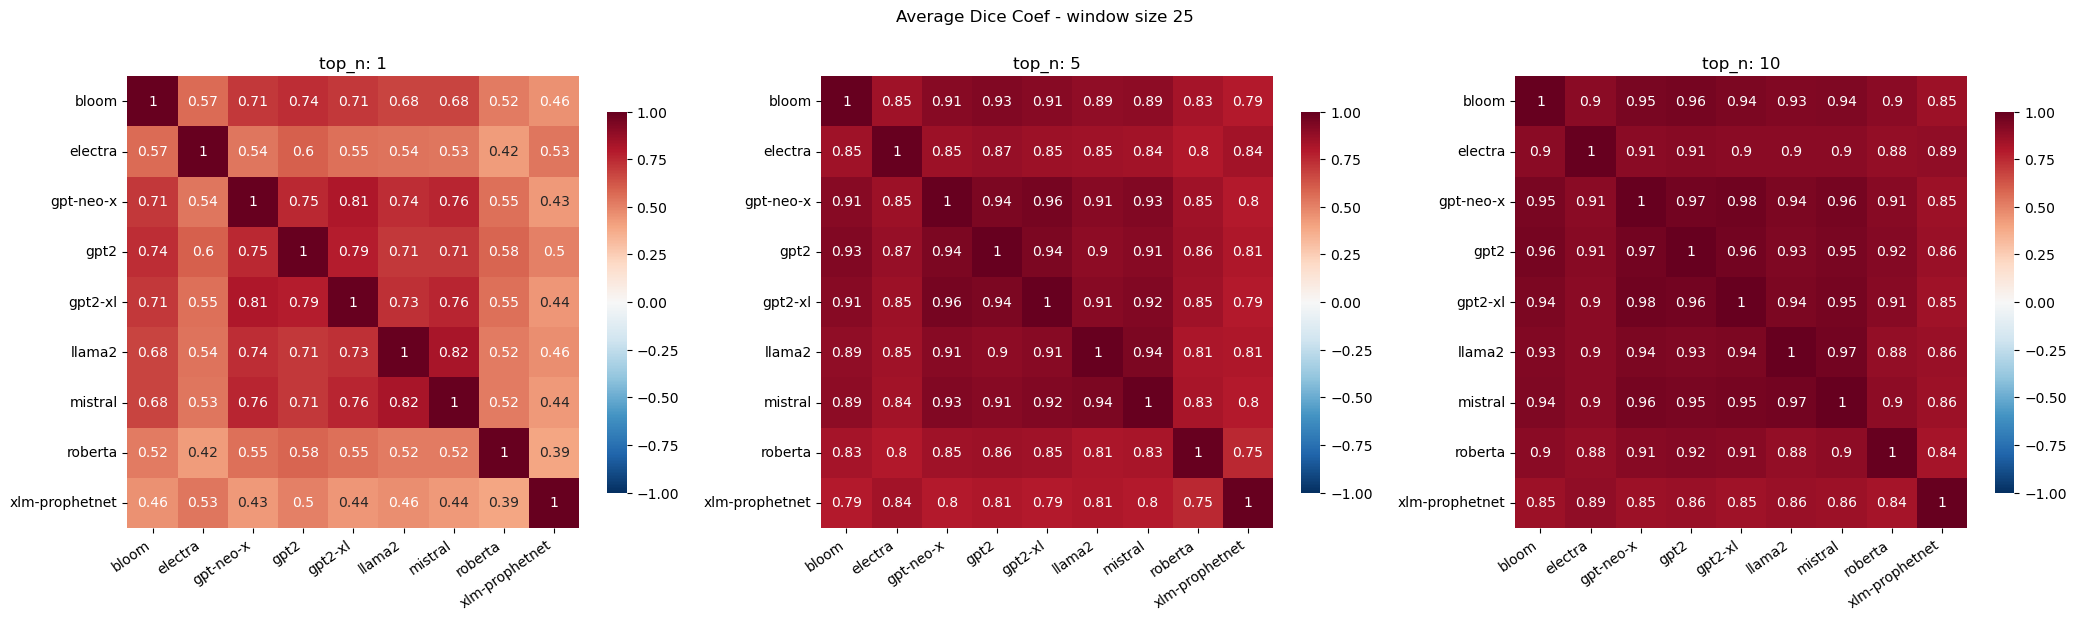

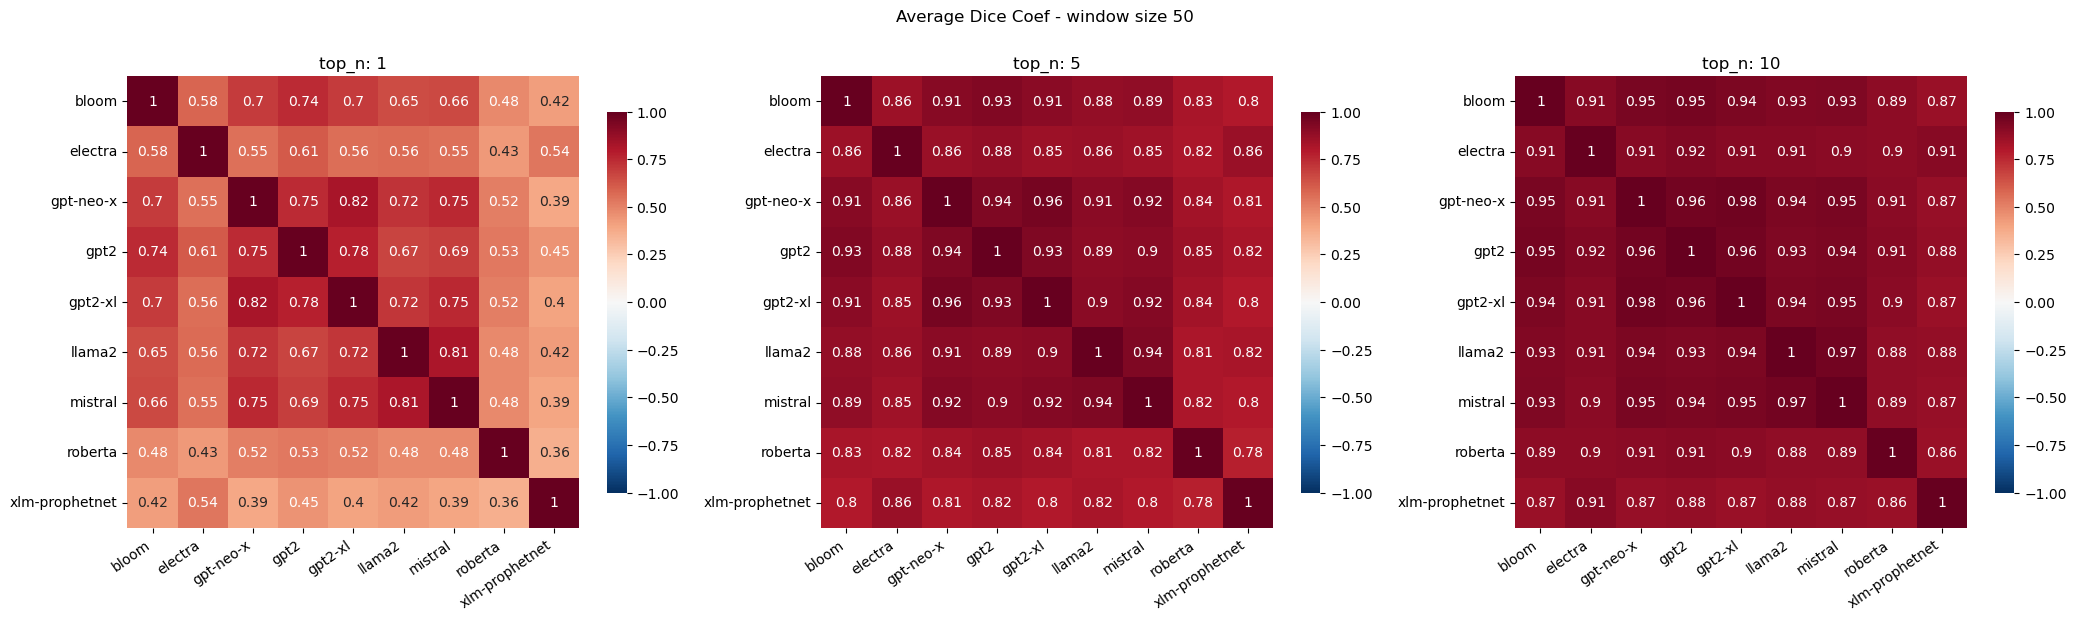

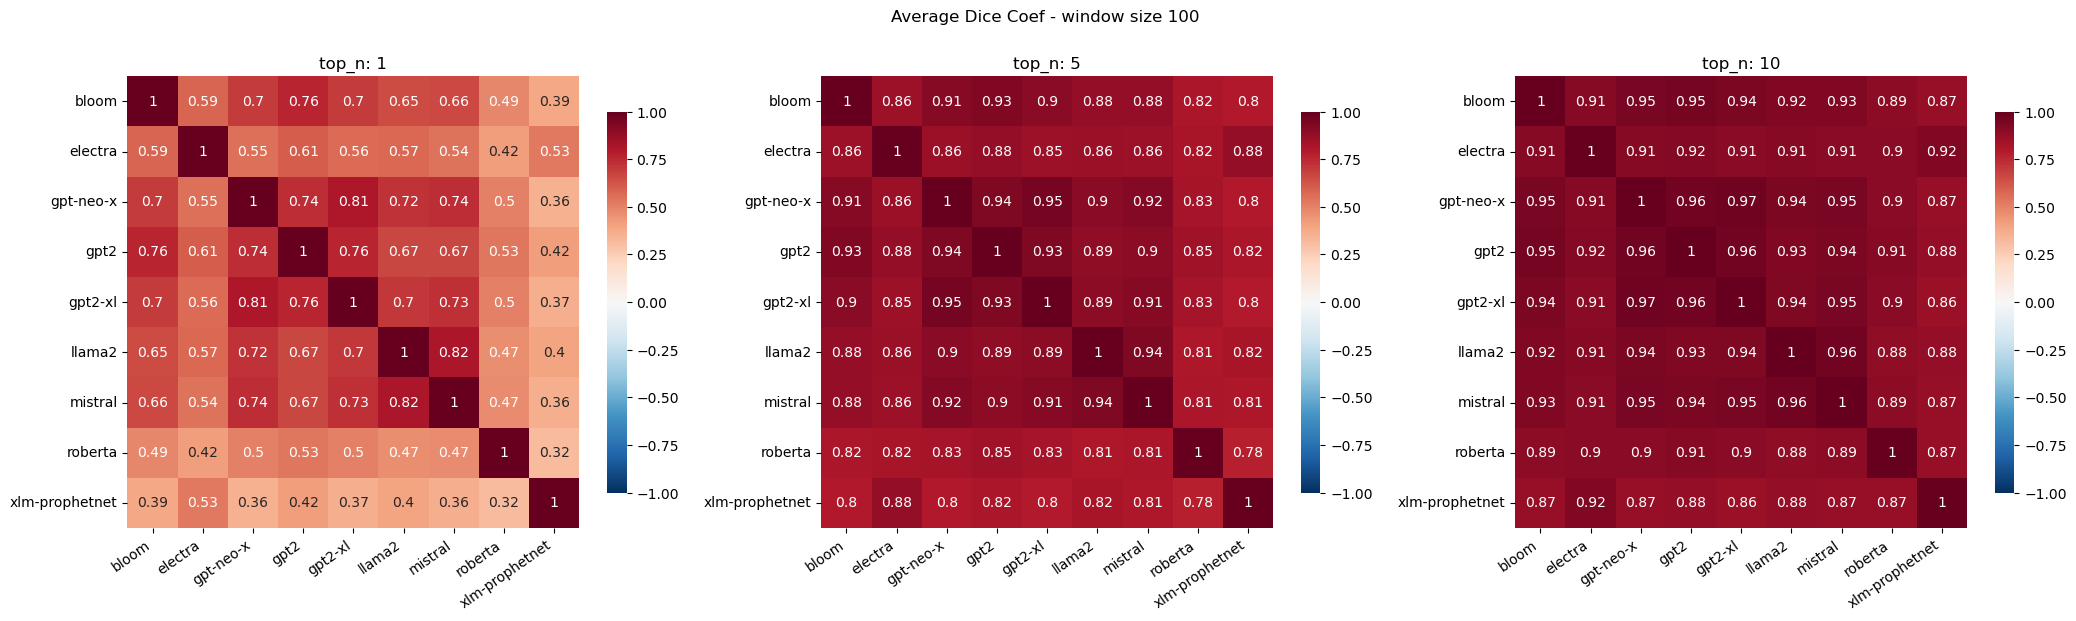

In [1155]:
for window_size in window_sizes:
    fig, axes = plot_model_similarity(all_results, groupvar='top_n', filtervar=['window_size', window_size], 
                                      result_type='word2vec_continuous_accuracy', metric='correlation')
    
    plt.suptitle(f'Average Dice Coef - window size {window_size}', y=0.9)
    plt.tight_layout()

In [1193]:
words = ['look', 'toy', 'grass']

word_vecs = np.stack([glove[word] for word in words])



NameError: name 'glove' is not defined

In [ ]:
sims = 1 - cdist(word_vecs, word_vecs, metric='cosine')

mask = ~np.eye(sims.shape[0],dtype=bool)
np.mean(sims[mask])

In [1191]:
sims = 1 - cdist(word_vecs, word_vecs, metric='cosine')

mask = ~np.eye(sims.shape[0],dtype=bool)
np.mean(sims[mask])

0.07513260499290342

In [1192]:
sims = 1 - cdist(word_vecs, word_vecs.mean(0)[np.newaxis], metric='cosine')
np.mean(sims)

0.614323892902897

/tmp/ipykernel_36120/2508186542.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_result = df_results.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \


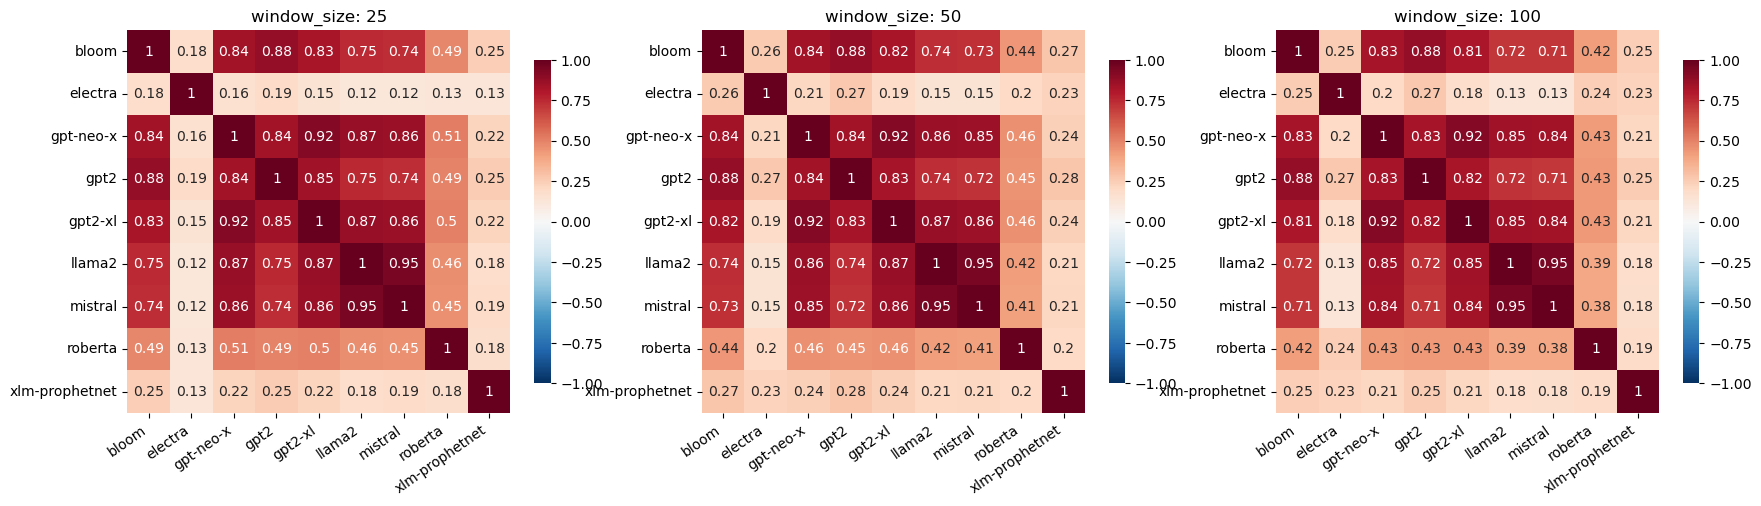

In [1161]:
fig, axes = plot_model_similarity(all_results, groupvar='window_size',
              result_type='entropy', metric='correlation')

/tmp/ipykernel_36120/4220570683.py:28: FutureWarning: The provided callable <function nanmean at 0x2b69c2c05940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_accuracy = all_accuracy.groupby(['model_pair', 'window_size', 'top_n'], as_index=False) \


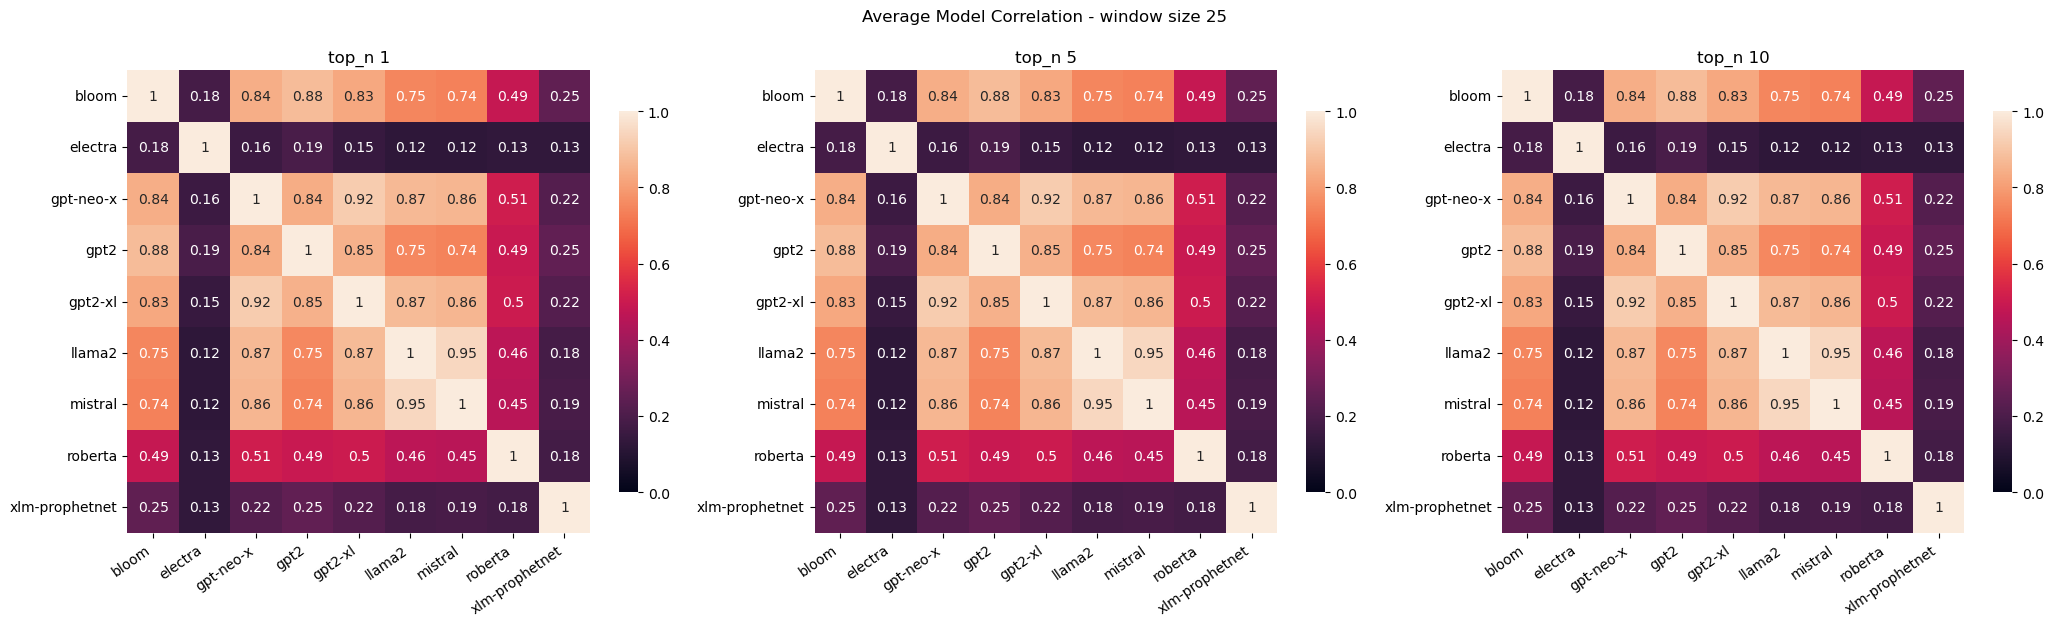

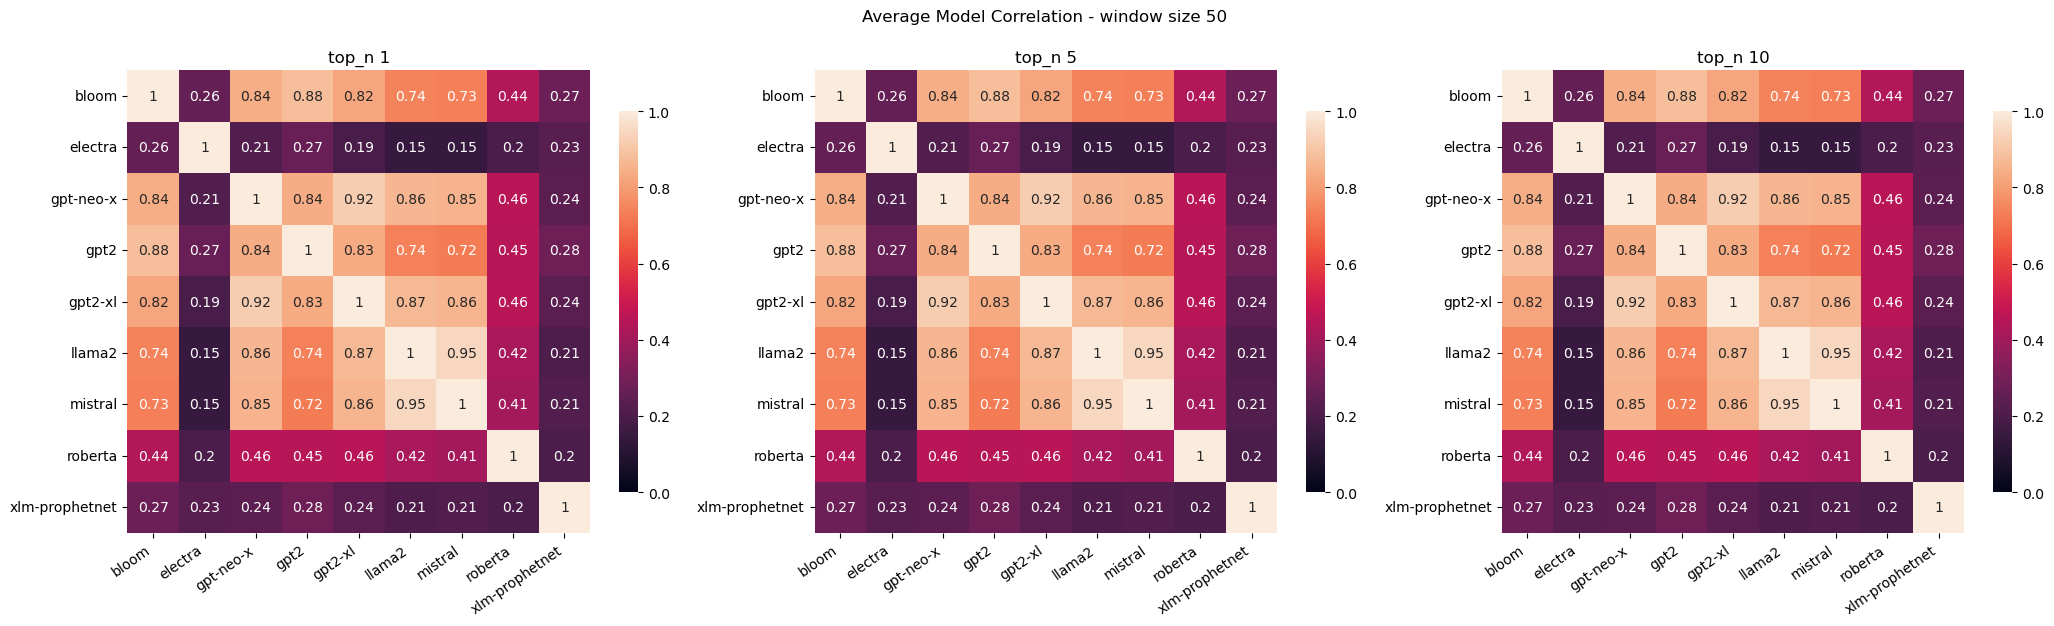

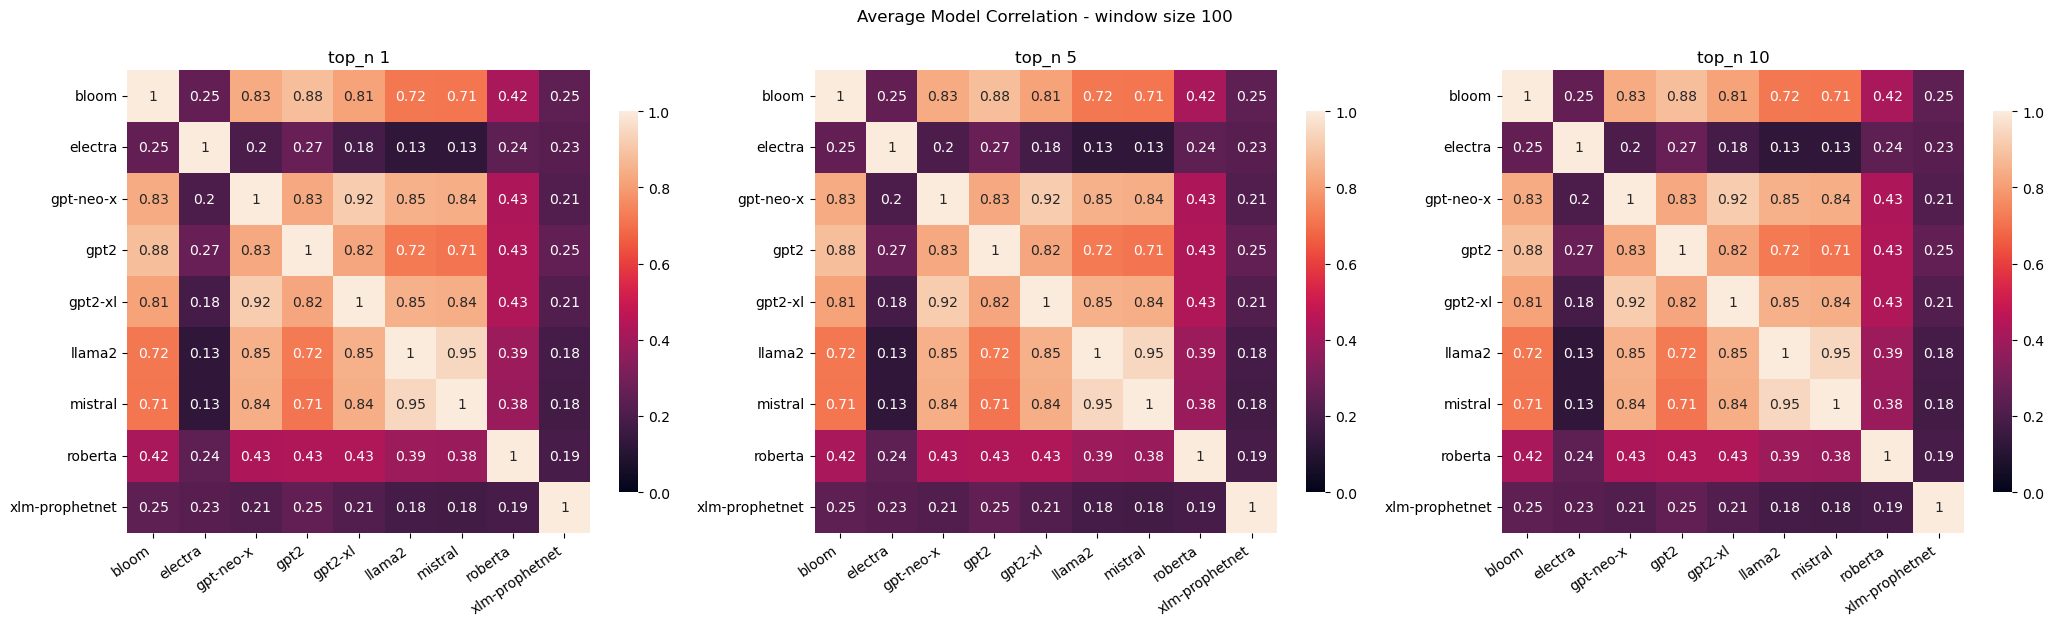

In [1089]:
avg_task_continuous_corr = get_pairwise_accuracy(all_results, accuracy_type='entropy', metric='correlation')

for window_size, df_window in avg_task_continuous_corr.groupby(['window_size']):
    
    fig, axes = plt.subplots(1, len(window_sizes), figsize=(21, 7))
    axes = axes.flatten()
    
    for ax, (top_n, df) in zip(axes, df_window.groupby(['top_n'])):
    
        corr_matrix = np.reshape(df['correlation'], (n_models, n_models))

        sns.heatmap(corr_matrix, annot=True, square=True, xticklabels=model_names, 
                         yticklabels=model_names, vmin=0, vmax=1, cbar_kws={"shrink": 0.6}, ax=ax)
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
        ax.title.set_text(f'top_n {top_n[0]}')
        
#         plt.tight_layout()
    plt.suptitle(f'Average Model Correlation - window size {window_size[0]}', y=0.9)
    plt.tight_layout()
#     sys.exit(0)

## Plot results for model predictions

In [1467]:
def plot_accuracy_by_group(df_group, x, y, hue, iterate_col=None, order=None, figsize=5):
    
    # group by the iterate column
    if not iterate_col:
        df_group['temp'] = 1
        iterate_col = 'temp'
    
    df_grouped = df_group.groupby(iterate_col)
    n_cols = len(df_grouped)
    
    # make the plot to plot over
    fig, axes = plt.subplots(1, n_cols, figsize=(figsize*n_cols, figsize))
    axes = axes.flatten()
    
    # now go through each grouped dataframe and plot
    for ax, (i, df) in zip(axes, df_grouped):
        ax = sns.boxplot(data=df, x=x, y=y, hue=hue, ax=ax, order=order, palette='Paired')
        
        if iterate_col != 'temp':
            ax.title.set_text(f'{iterate_col}: {i}')
    
    return fig, axes

In [434]:
df_test = df_scores[(df_scores['top_n'] == 5) & (df_scores['window_size'] == 25)]

accuracy_columns = ['avg_binary_accuracy', 'avg_glove_accuracy', 'avg_word2vec_accuracy']

grouped = df_test.loc[:,['model_name', 'avg_binary_accuracy']] \
    .groupby(['model_name']) \
    .median() \
    .sort_values(by='avg_binary_accuracy')

In [460]:
accuracy_max = df_scores[accuracy_columns].to_numpy().max()
accuracy_min = df_scores[accuracy_columns].to_numpy().min()

accuracy_max *= 1.2
accuracy_min = -0.05

grouped = df_scores.loc[:,['model_name', 'avg_binary_accuracy']] \
    .groupby(['model_name']) \
    .median() \
    .sort_values(by='avg_binary_accuracy')

df_scores = df_scores.melt(id_vars=['model_name', 'task', 'top_n', 'window_size'], 
                           var_name='accuracy_type', value_name='accuracy')

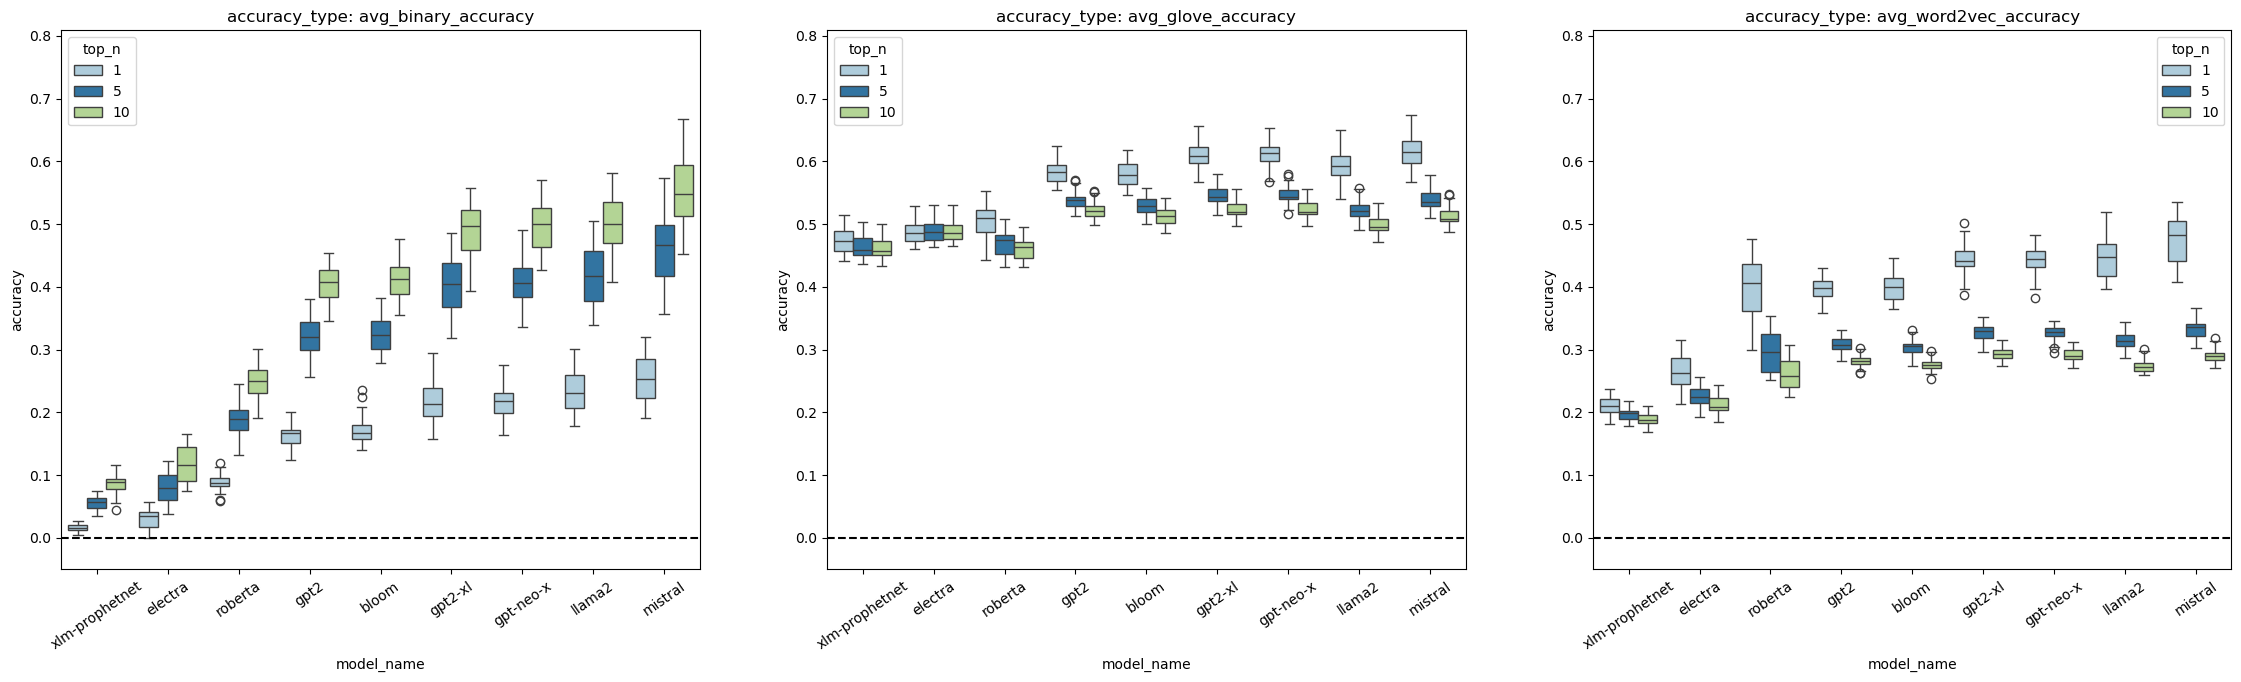

In [495]:
fig, axes = plot_accuracy_by_group(df_scores, 
                                   iterate_col='accuracy_type', 
                                   x='model_name', 
                                   y='accuracy', 
                                   hue='top_n', 
                                   order=grouped.index,
                                   figsize=7)

for ax in axes:
    ax.xaxis.set_tick_params(rotation=35)
    ax.set_ylim(accuracy_min, accuracy_max)
    ax.axhline(0, linestyle='--', c='k')
    
# plt.suptitle(f'Model performance - {accuracies[0]}')
# plt.tight_layout()

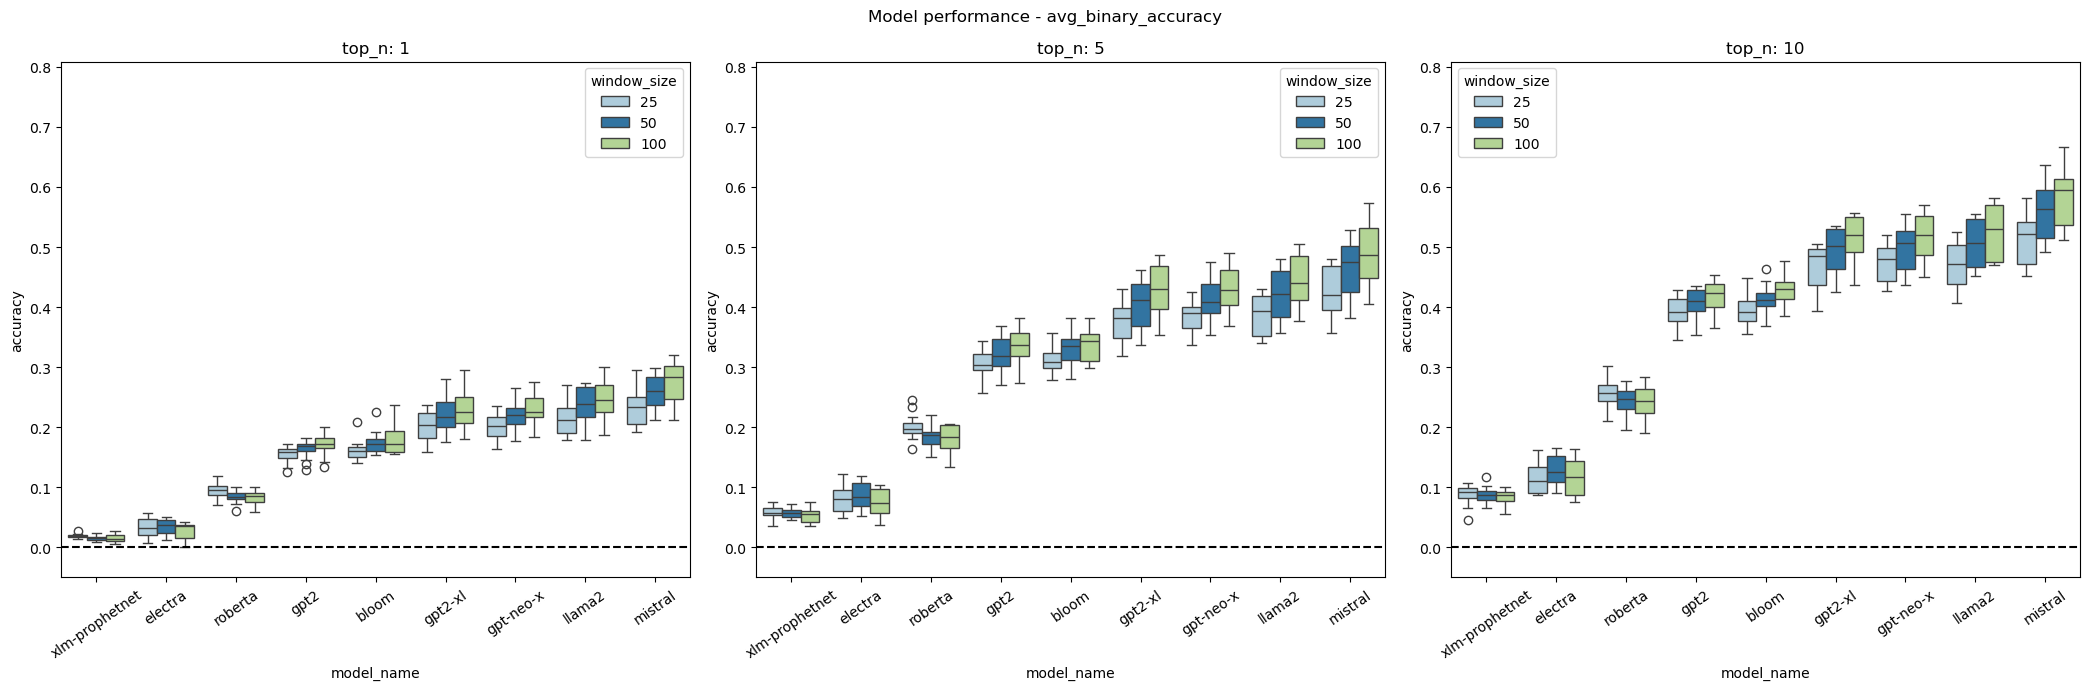

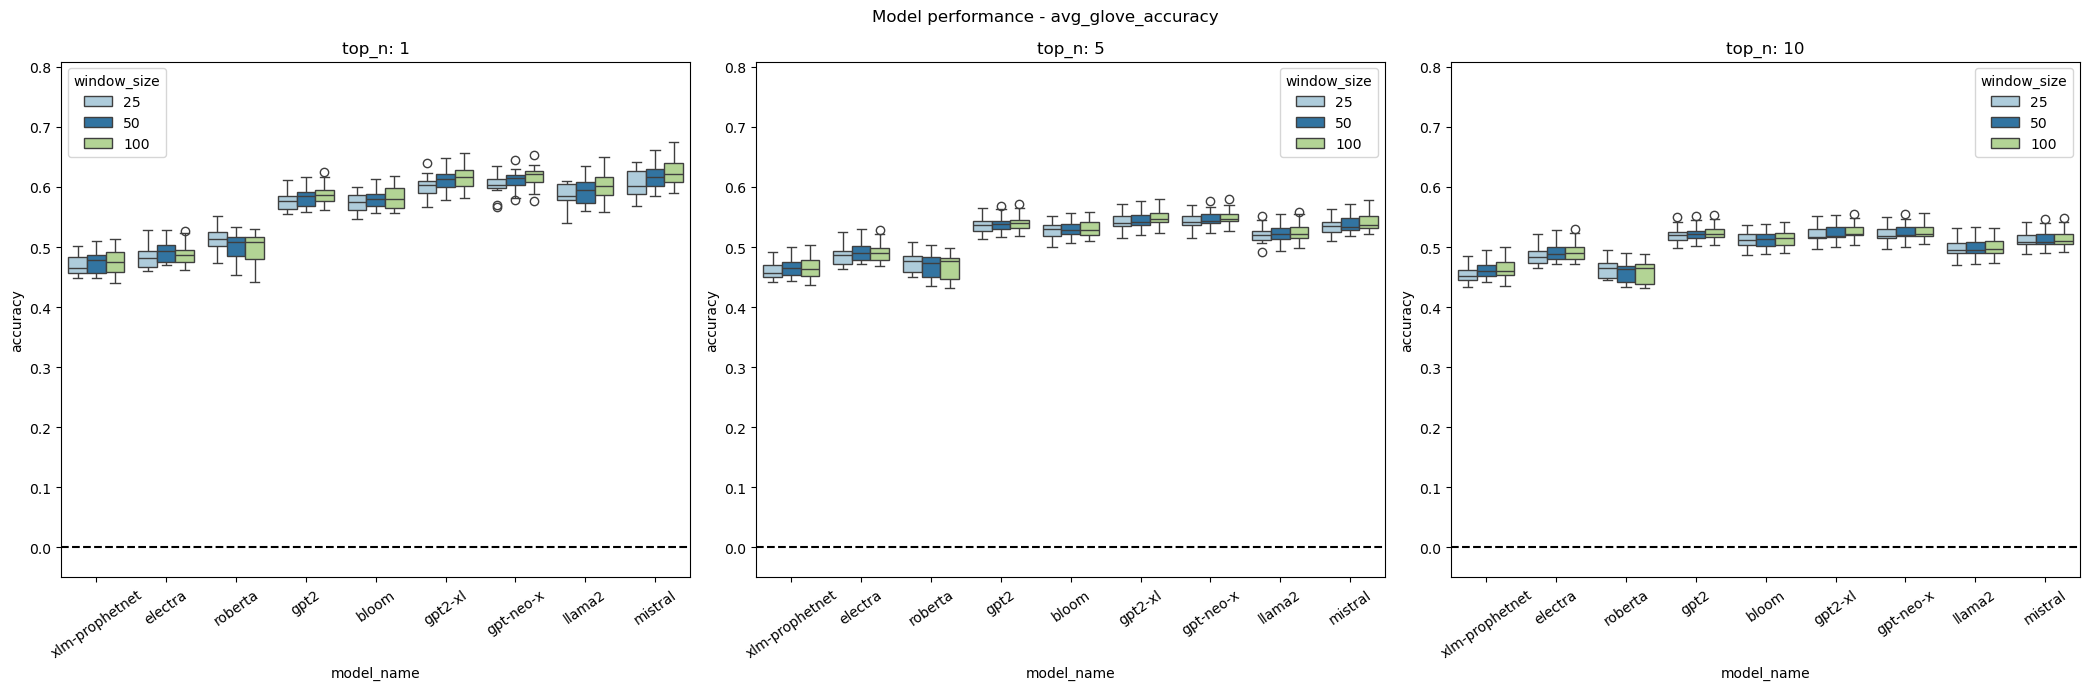

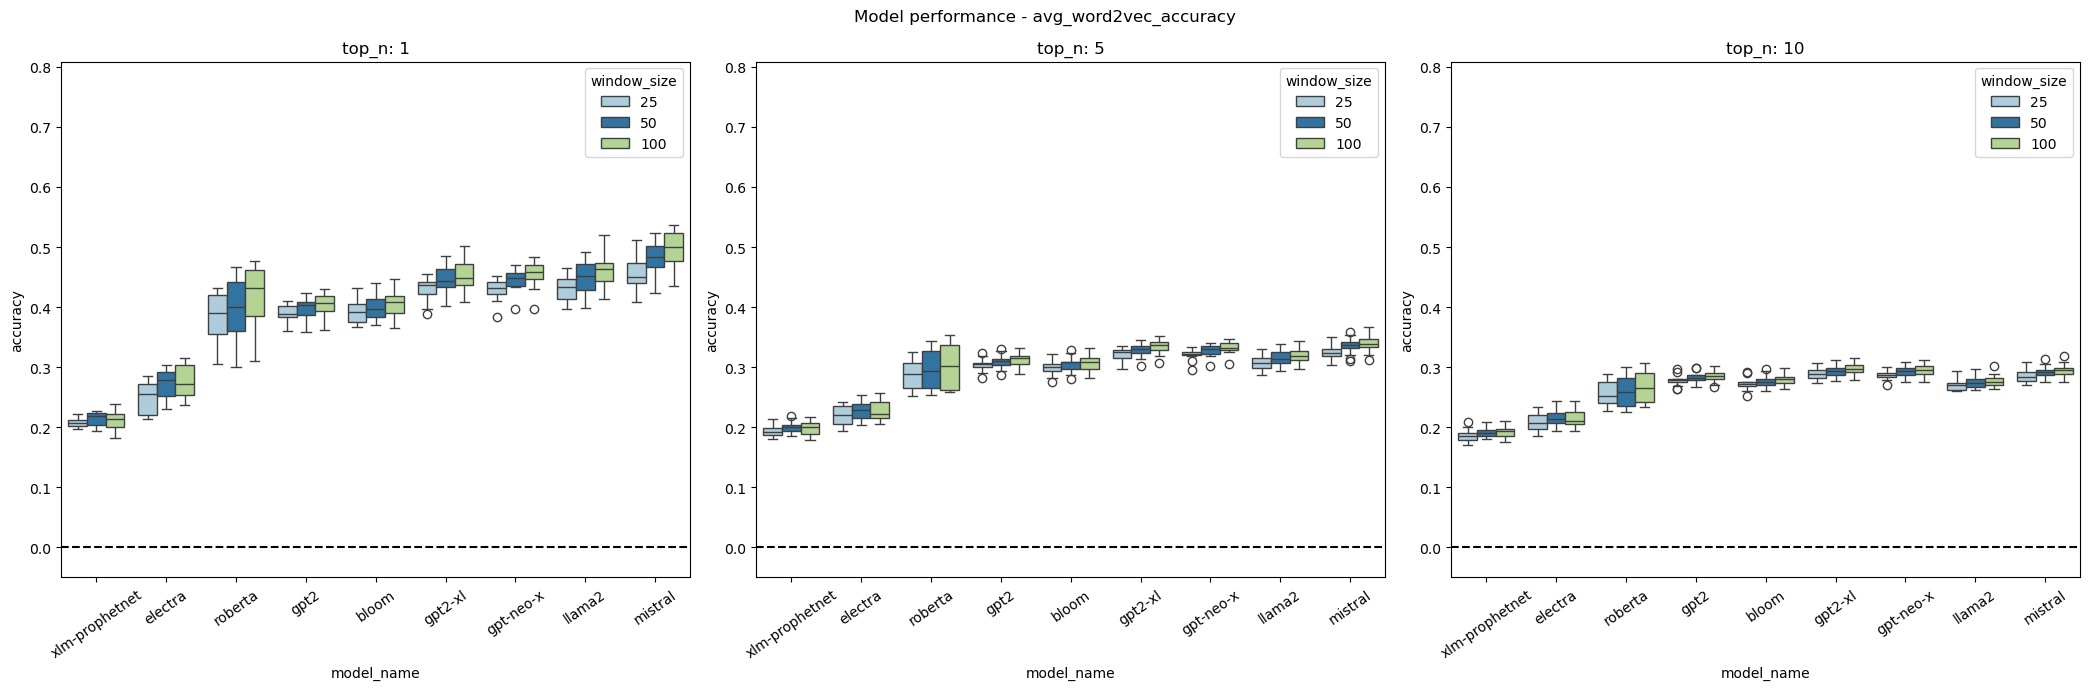

In [519]:
for accuracy_type, df in df_melt.groupby('accuracy_type'):

    fig, axes = plot_accuracy_by_group(df, 
                                       iterate_col='top_n', 
                                       x='model_name', 
                                       y='accuracy', 
                                       hue='window_size', 
                                       order=grouped.index,
                                       figsize=7)
    for ax in axes:
        ax.xaxis.set_tick_params(rotation=35)
        ax.set_ylim(accuracy_min, accuracy_max)
        ax.axhline(0, linestyle='--', c='k')

    plt.suptitle(f'Model performance - {accuracy_type}')
    plt.tight_layout()
    
#     sys.exit(0)



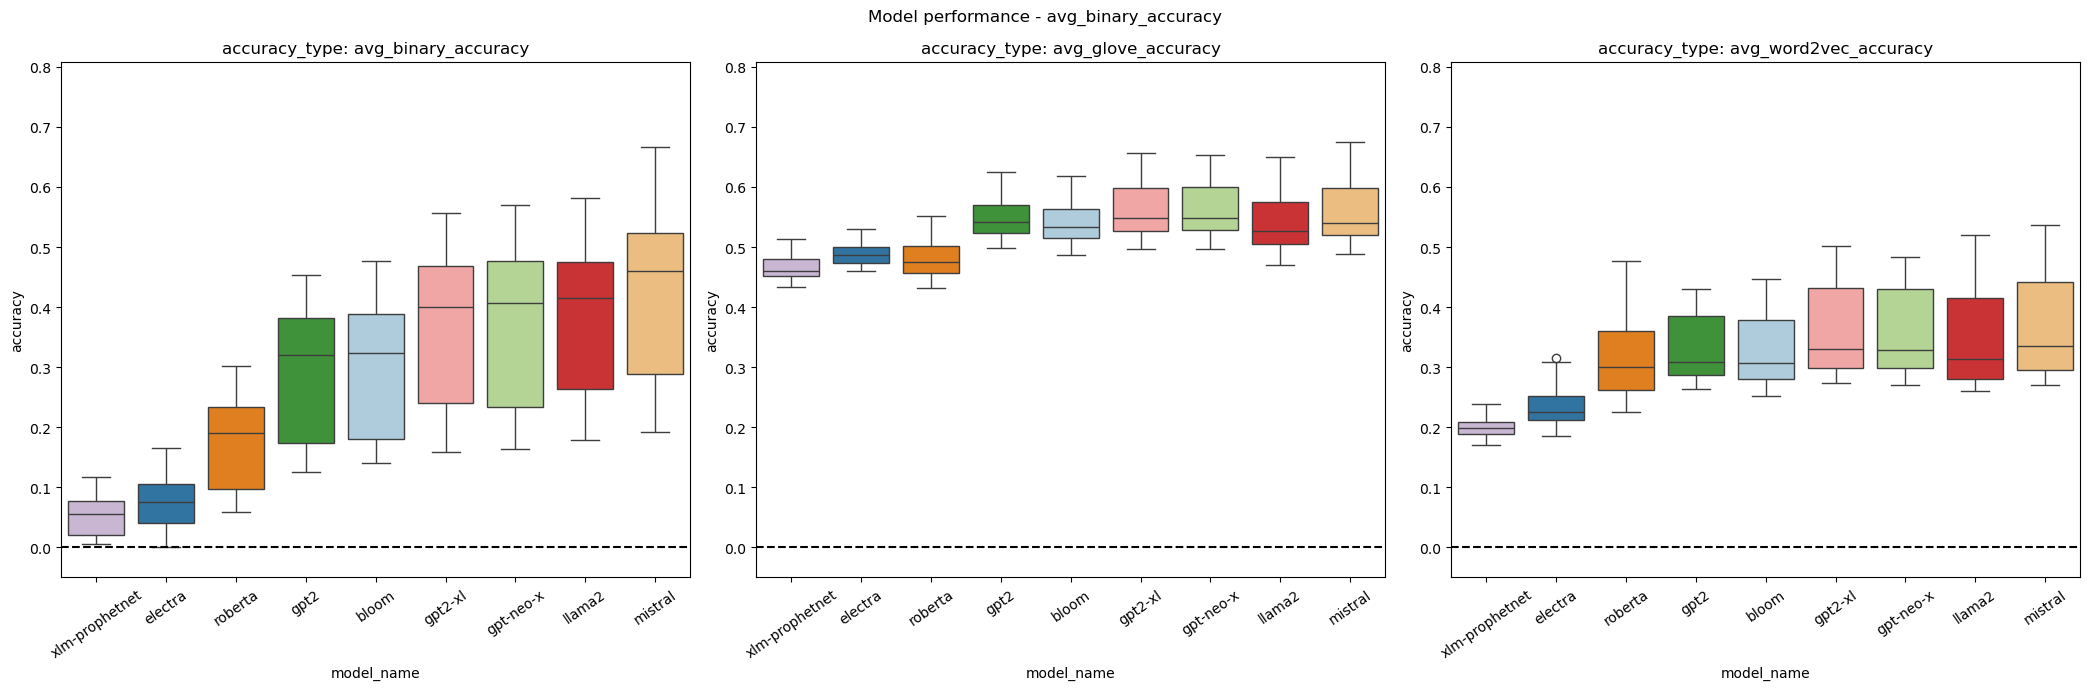

In [526]:
fig, axes = plot_accuracy_by_group(df_scores, 
                                   iterate_col='accuracy_type', 
                                   x='model_name', 
                                   y='accuracy', 
                                   hue='model_name', 
                                   order=grouped.index,
                                   figsize=7)
for ax in axes:
    ax.xaxis.set_tick_params(rotation=35)
    ax.set_ylim(accuracy_min, accuracy_max)
    ax.axhline(0, linestyle='--', c='k')

plt.suptitle(f'Model performance - all averages')
plt.tight_layout()

In [17]:
%autoreload 2
from nlp_utils import download_gensim_model, load_gensim_model, load_mlm_model, get_segment_indices
from scipy.spatial.distance import cdist
from ast import literal_eval

fn = download_gensim_model('glove.42B.300d', cache_dir=CACHE_DIR)
word_model = load_gensim_model(fn)

# vec = word_model[test_word][np.newaxis]
# test_vecs = np.stack([word_model[word] for word in test_preds])

# sims = 1 - cdist(vec, test_vecs, metric='cosine')
# np.mean(sims)

Loading glove.42B.300d from saved .bin file.


Test contextual embedding

In [22]:
def preproc_to_input(df_preproc, idxs, window_size, bidirectional=False):
    '''
    Given the preprocessed dataframe, extract the transcript text
    over a set of indices to submit to a model
    '''

    # get the GT upcoming word to predict
    if bidirectional:
        if len(df_preproc) == (idxs[-1] + 1):
            target_idx = idxs[(window_size//2) - len(idxs)]
        else:
            target_idx = idxs[len(idxs) - (window_size//2) - 1]
    else:
        target_idx = idxs[-1] + 1
        
    ground_truth_word = df_preproc.loc[target_idx, 'Word_Written']

    # get the segment to submit to the model
    df_segment = df_preproc.iloc[idxs]
    
    context = []

    for i, row in df_segment.iterrows():
        # sometimes there is punctuation, other times there is whitespace
        # we add in the punctuation as it helps the model but remove trailing
        # whitespaces
        print (row[['Word_Written', 'Punctuation']])
        item = ''.join(row[['Word_Written', 'Punctuation']])
        context.append(item.strip())

    context = ' '.join(context)

    return context, ground_truth_word

In [654]:
def get_context_sentences(context, preds, target_index, indices):
    
    context = context.split(' ')
    
    # find the target word in the sentence
    target_word_idx = np.argwhere(indices[target_index] == target_index).squeeze().tolist()
    
    context_sentences = []
    
    # for each predicted word --> substitute the word in the sentence
    for pred in preds:
        pred_sentence = context.copy()
        pred_sentence[target_word_idx] = pred
        
        # the join and append to the sentences
        pred_sentence = ' '.join(pred_sentence)
        context_sentences.append(pred_sentence)
    
    return context_sentences

In [24]:
task = 'black'
stim_preprocessed_fn = os.path.join(stim_dir, 'preprocessed', task, f'{task}_transcript-preprocessed.csv')
df_preproc = pd.read_csv(stim_preprocessed_fn)

In [25]:
# get all indices bidirectionally for the current story
indices = get_segment_indices(n_words=len(df_preproc), window_size=25, bidirectional=False)

In [26]:
context, target_word = preproc_to_input(df_preproc, indices[4], window_size=25, bidirectional=False)

Word_Written    So
Punctuation       
Name: 0, dtype: object
Word_Written    I
Punctuation      
Name: 1, dtype: object
Word_Written    was
Punctuation        
Name: 2, dtype: object
Word_Written    a
Punctuation      
Name: 3, dtype: object
Word_Written    junior
Punctuation           
Name: 4, dtype: object


In [15]:
df_preproc

,Word_Written,Case,POS,POS_Definition,Punctuation,Stop_Word,Word_Vocab,Onset,Offset,Duration,Named_Entity,NWP_Candidate
0,I,success,PRP,"pronoun, personal",NaN,True,I,0.012472,0.142177,0.129705,False,False
1,reached,success,VBD,"verb, past tense",NaN,False,reached,0.142177,0.501361,0.359184,False,True
2,over,success,RB,adverb,NaN,True,over,0.501361,0.960317,0.458957,False,False
3,and,success,CC,"conjunction, coordinating",NaN,True,and,1.539002,1.688662,0.149660,False,False
4,secretly,success,RB,adverb,NaN,False,secretly,1.728571,2.377098,0.648526,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1822,I,success,PRP,"pronoun, personal",NaN,True,I,590.470522,590.630159,0.159637,False,False
1823,still,success,RB,adverb,NaN,False,still,590.630159,590.999320,0.369161,False,True
1824,miss,success,VBP,"verb, present tense, not 3rd person singular",NaN,False,miss,590.999320,591.188889,0.189569,False,True
1825,the,success,DT,determiner,NaN,True,the,591.188889,591.298640,0.109751,False,False


In [856]:
tokenizer, model = load_mlm_model(model_name='bert-base-cased', cache_dir=CACHE_DIR)

In [978]:
df_preproc

,Word_Written,Case,POS,POS_Definition,Punctuation,Stop_Word,Word_Vocab,Onset,Offset,Duration,Named_Entity,NWP_Candidate
0,Tonight,success,NNP,"noun, proper, singular",",",False,Tonight,0.12,0.48,0.36,False,True
1,a,success,DT,determiner,,True,a,0.69,0.80,0.11,False,False
2,story,success,NN,"noun, common, singular or mass",,False,story,0.80,1.21,0.41,False,True
3,by,success,IN,"preposition or conjunction, subordinating",,True,by,1.21,1.46,0.25,False,False
4,Frederik,assumed,NNP,"noun, proper, singular",,False,Frederik,1.46,1.47,0.01,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3418,out,success,IN,"preposition or conjunction, subordinating",,True,out,1515.27,1515.36,0.09,False,False
3419,of,success,IN,"preposition or conjunction, subordinating",,True,of,1515.36,1515.49,0.13,False,False
3420,a,success,DT,determiner,,True,a,1515.49,1515.54,0.05,False,False
3421,dream,success,NN,"noun, common, singular or mass",,False,dream,1515.54,1516.00,0.46,False,True


In [993]:
# get all indices bidirectionally for the current story
indices = get_segment_indices(n_words=len(df_preproc), window_size=25, bidirectional=True)

In [1030]:
import ast
import torch

# get all indices bidirectionally for the current story
indices = get_segment_indices(n_words=len(df_preproc), window_size=25, bidirectional=True)

all_punctuation = f'{string.punctuation}...--’“?”.".”'

# then go through each word to predict
for i, target_index in enumerate(model_results.index):
    if i == 0:
        continue
    
    print (f'Run {i}/{len(model_results)}')
    
    context, target_word = preproc_to_input(df_preproc, indices[target_index], window_size=25, bidirectional=True)
    context = ' '.join([word for word in context.split() if word not in all_punctuation])
#     context = strip_punctuation(context)
    
    # get the predicted words at the current target index
    # remove punctuation from the list
    preds = ast.literal_eval(model_results.loc[target_index]['top_n_predictions'])
    preds = [pred for pred in preds if pred not in all_punctuation]
    
    # create the sentences with the predicted words substituted
    pred_context_sentences = get_context_sentences(context, preds, target_index, indices)
    
    # find the target word in the sentence
    target_word_idx = np.argwhere(indices[target_index] == target_index).squeeze().tolist()
    
    # extract embeddings of target word
    gt_embedding = extract_word_embeddings(context, tokenizer, model, word_indices=target_word_idx)
    pred_embeddings = extract_word_embeddings(pred_context_sentences, tokenizer, model, word_indices=target_word_idx)
    
    # calculate cosine similarity
    similarity = 1 - cdist(gt_embedding, pred_embeddings, metric='cosine')
    
    print (f'Target word: {target_word}')
    print (f'Target context: {context}')
    print (f'Predicted words: {preds}')
    print (f'Average similarity: {np.nanmean(similarity)}\n\n')
    
    model_results.loc[target_index, 'bert_continuous_accuracy'] = np.nanmean(similarity)
    

Run 1/1401
Target word: story
Target context: Tonight, a story by Frederik Pohl: Tunnel Under the World. On the morning of June
Predicted words: ['new', 'group', 'few', 'friend', 'very']
Average similarity: 0.7428525685080795


Run 2/1401
Target word: morning
Target context: Tonight, a story by Frederik Pohl: Tunnel Under the World. On the morning of June fifteenth, Guy Burckhardt woke up screaming. It was more real
Predicted words: ['surface', 'other', 'night', 'back']
Average similarity: 0.6396398879570178


Run 3/1401
Target word: June
Target context: story by Frederik Pohl: Tunnel Under the World. On the morning of June fifteenth, Guy Burckhardt woke up screaming. It was more real than any
Predicted words: ['the', 'october', 'september', 'january']
Average similarity: 0.5100963145925245


Run 4/1401
Target word: fifteenth
Target context: by Frederik Pohl: Tunnel Under the World. On the morning of June fifteenth, Guy Burckhardt woke up screaming. It was more real than any dream
Pred


KeyboardInterrupt



In [1031]:
# create the sentences with the predicted words substituted
pred_context_sentences = get_context_sentences(context, [], target_index, indices)

In [1035]:
pred_embeddings = extract_word_embeddings(pred_context_sentences, tokenizer, model, word_indices=target_word_idx)


In [1036]:
pred_embeddings

[]

In [1029]:
model_results[['binary_accuracy', 'continuous_accuracy', 'bert_continuous_accuracy']].corr()

,binary_accuracy,continuous_accuracy,bert_continuous_accuracy
binary_accuracy,1.000000,0.562055,0.423972
continuous_accuracy,0.562055,1.000000,0.268513
bert_continuous_accuracy,0.423972,0.268513,1.000000


In [1034]:
def subwords_to_words(sentence, tokenizer, regex_expr=r"[\w]+['\u2019-]?[\w]*['\u2019-]?[\w]*['\u2019-]?[\w]*"):
    '''
    Need to find a bette rway of matching multiple times in a row
    '''
    word_token_pairs = []
    
    # split the sentence on spaces + punctuation (excluding apostrophes and hyphens within words)
    for m in re.finditer(regex_expr, sentence):
        word = m.group(0)
        tokens = tokenizer.encode(word, add_special_tokens=False)
        char_idxs = (m.start(), m.end()-1)
        
        word_token_pairs.append((word, tokens, char_idxs))
    
    return word_token_pairs

def extract_word_embeddings(sentences, tokenizer, model, word_indices=None):
    '''
    Given a list of sentences, pass them through the tokenizer/model. Then pair
    sub-word tokens into the words of the actual sentence and extract the true
    word embeddings. 
    
    If wanted, can return only certain indices (specified by word_indices)
    
    '''
    
    if isinstance(sentences, str):
        sentences = [sentences]
        
    if not sentences:
        return []
    
    # get the full sentence tokenized
    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    
    # get the embeddings
    with torch.no_grad():
        model_output = model(**encoded_inputs)
    
    all_embeddings = []
    
    # bring together the current sentence, its tokens, and its embeddings
    for i, sent in enumerate(sentences):
        
        # now pair subwords into words for the current sentence
        subword_word_pairs = subwords_to_words(sent, tokenizer)
        
        embeddings = []
        
        # for the current set of word subword pairs, get the embeddings
        for (word, tokens, char_span) in subword_word_pairs:
            
            # given the character to token mapping in the sentence, 
            # find the first and last token indices
            start_token = encoded_inputs.char_to_token(batch_or_char_index=i, char_index=char_span[0])
            end_token = encoded_inputs.char_to_token(batch_or_char_index=i, char_index=char_span[-1])
            
            # extract the embedding for the given word
            word_embed = model_output['last_hidden_state'][i, start_token:end_token+1, :].mean(0)
            embeddings.append(word_embed)
            
        # stack the embeddings together
        embeddings = torch.stack(embeddings)
        
        # make sure the mapping happened correctly
        assert (len(sent.split()) == embeddings.shape[0])
        
        all_embeddings.append(embeddings)
    
    # stack and pad the embeddings
    all_embeddings = pad_sequence(all_embeddings, batch_first=True)
    
    if word_indices:
        return all_embeddings[:, word_indices, :]
    else:
        return all_embeddings

NameError: name 'group_sorted' is not defined

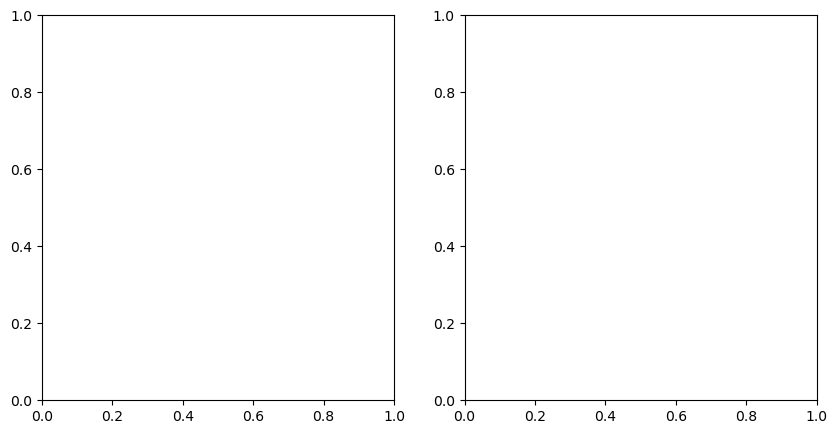

In [28]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

accuracies = ['avg_binary_accuracy', 'avg_continuous_accuracy']
titles = ['Binary accuracy', 'Continuous accuracy']

for i, ax in enumerate(axes):
    sns.boxplot(df_scores, y='model', x=accuracies[i], order=group_sorted.index, hue="model", palette='Paired', ax=ax)
    ax.set_xlim([0, df_scores[accuracies[i]].max() + 0.1])
    ax.set_title(titles[i])
plt.tight_layout()
plt.suptitle(f'Model accuracy on candidate predictions (N={len(tasks)} stories)', y=1.05)

Load results dataframes

In [1269]:
# load model results and trim down to the candidate indices
task = 'wheretheressmoke'

model_results = load_model_data(model_dir, model_name='gpt2-xl', task=task, top_n=5, window_size=100)
candidate_idxs = get_stim_candidate_idxs(task)
model_results = model_results.iloc[candidate_idxs]
model_results.loc[:, 'binary_accuracy'] = model_results['binary_accuracy'].astype(bool)

Is continuous accuracy higher when binary accuracy was correct?

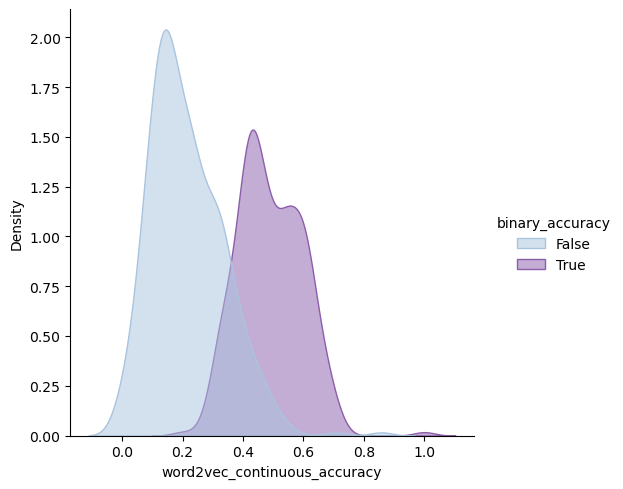

In [1270]:
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt

df_false, df_true = [df.dropna() for _, df in model_results.groupby('binary_accuracy')]
test_column = 'word2vec_continuous_accuracy'

tstat, pval = ttest_ind(df_true[test_column], df_false[test_column])

if pval < 0.001:
    pval = f'p < 0.001'
else:
    pval = f'p = {pval:.3f}'

sns.displot(x="word2vec_continuous_accuracy", 
            hue="binary_accuracy", 
            data=model_results, 
            palette='BuPu', 
            kind='kde', 
            fill=True, alpha=0.5)

# ax = plt.gca()
# ax.text(1, 0.1, f'tstat = {tstat:.2f}, {pval}', bbox=dict(facecolor='none', edgecolor='black', pad=5.0))
# plt.title('Continuous accuracy is higher when binarily correct')

Is entropy lower when the model was correct?

In [1271]:
from scipy.stats import pearsonr

def get_correlation_stats(df, x, y, group):
    
    corr_stats = {}
    
    for i, df in df.groupby(group):
        df = df.dropna()
        rval, pval = pearsonr(df[x], df[y])
        
        if pval < 0.001:
            pval = 'p < 0.001'
        else:
            pval = f'p = {pval:.3f}'
        
        corr_stats[i] = {'rval': f'{rval:.2f}', 'pval': pval}
    return corr_stats
        
    
    
def create_binarized_correlation_labels(df, x, y, group):
    
    all_labels = []
    corr_stats = get_correlation_stats(df, x=x, y=y, group=group)

    for key, vals in corr_stats.items():
        if key:
            label = f"Correct - r = {vals['rval']}, {vals['pval']}"
        else:
            label = f"Incorrect - r = {vals['rval']}, {vals['pval']}"

        all_labels.append(label)

#     all_labels = '\n'.join(all_labels)
    return all_labels

Text(0.5, 1.0, 'Closer to correct predictions are more certain (lower entropy)')

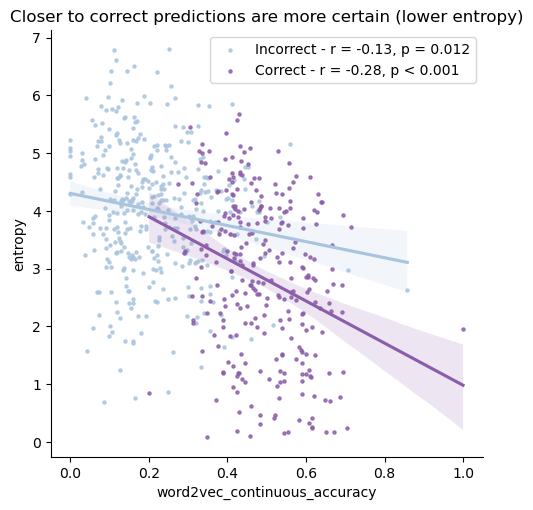

In [1272]:
sns.lmplot(x="word2vec_continuous_accuracy", 
           y="entropy", 
           hue="binary_accuracy", 
           data=model_results, 
           scatter_kws={"s": 5}, 
           palette='BuPu',
           legend=False)

labels = create_binarized_correlation_labels(model_results, x='word2vec_continuous_accuracy', y='entropy', group='binary_accuracy')

ax = plt.gca()
handles, _ = ax.get_legend_handles_labels()

# reverse the order
ax.legend(handles, labels)

plt.title('Closer to correct predictions are more certain (lower entropy)')

Do correct predictions have a lower relative entropy? In other words, does the certainty of my prediction result in a smaller shift in the distribution

Text(0.5, 1.0, 'Correct responses do not necessarily reduce entropy of distribution')

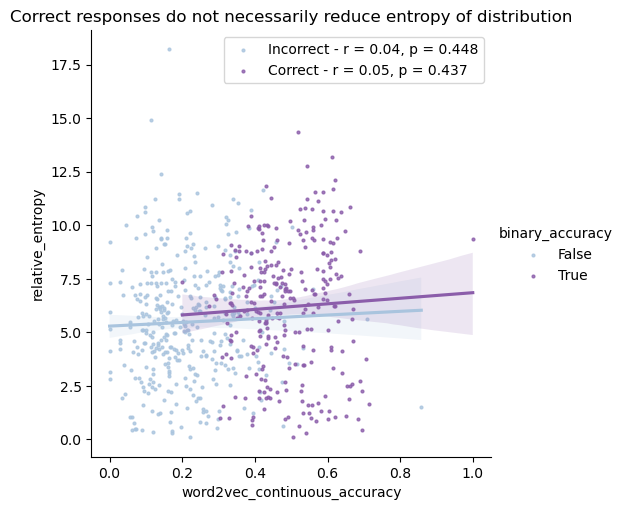

In [1273]:
sns.lmplot(x="word2vec_continuous_accuracy", 
           y="relative_entropy", 
           hue="binary_accuracy", 
           data=model_results, 
           scatter_kws={"s": 4}, 
           palette='BuPu')

labels = create_binarized_correlation_labels(model_results, x='word2vec_continuous_accuracy', y='relative_entropy', group='binary_accuracy')

ax = plt.gca()
handles, _ = ax.get_legend_handles_labels()

# reverse the order
ax.legend(handles, labels)

plt.title('Correct responses do not necessarily reduce entropy of distribution')


# Try separating data into bins

We're going to create a 2x2 structure as follows:
- accuracy (high vs. low)
- entropy (high vs. low)

In [1355]:
def divide_nwp_dataframe(df, accuracy_type, percentile):
    
    df_divide = df.copy()
    
    # first find the lowest and highest percentile for entropy
    low_entropy_idxs = df['entropy'] < np.nanpercentile(df['entropy'], percentile)
    high_entropy_idxs = df['entropy'] >= np.nanpercentile(df['entropy'], 100-percentile)
    
    ## set names for entropy group
    df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
    df_divide.loc[high_entropy_idxs, 'entropy_group'] = 'high'
    
    # repeat for continuous accuracy
    low_accuracy_idxs = df[accuracy_type] < np.nanpercentile(df[accuracy_type], percentile)
    high_accuracy_idxs = df[accuracy_type] >= np.nanpercentile(df[accuracy_type], 100-percentile)
    
    ## set names for accuracy group
    df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
    df_divide.loc[high_accuracy_idxs, 'accuracy_group'] = 'high'
    
    return df_divide.dropna()
        
def stat_test_sampled_df(df, groups_IV, groups_DV):
    
    # group 0 DV should not differ based on group 1 IV
    formula_g1 = f"{groups_DV[0]} ~ {groups_IV[0]} + {groups_IV[1]} + {groups[0]}:{groups[1]}"
    model_g1 = ols(formula_g1, data=df_stack).fit()
    anova_table_g1 = sm.stats.anova_lm(model_g1, typ=3)
    print (f'Formula 1: {formula_g1}')
    print (f'Does {groups_DV[0]} differ by {groups_IV[1]}?')

    pval_res_g1 = anova_table_g1.loc[groups[1], "PR(>F)"]
    print (f'Differs: {pval_res_g1 >= 0.05}, pval: {pval_res_g1:.5f}')

    # group 1 DV should not differ based on group 0 IV
    formula_g2 = f"{groups_DV[1]} ~ {groups_IV[0]} + {groups_IV[1]} + {groups[0]}:{groups[1]}"
    model_g2 = ols(formula_g2, data=df_stack).fit()
    anova_table_g2 = sm.stats.anova_lm(model_g2, typ=3)

    print (f'\nDoes {groups_DV[1]} differ by {groups_IV[0]}?')
    print (f'Formula 2: {formula_g2}')

    pval_res_g2 = anova_table_g2.loc[groups[0], "PR(>F)"]
    print (f'Differs: {pval_res_g2 >= 0.05}, pval: {pval_res_g2:.5f}')
    
    return pval_res_g1, pval_res_g2

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_test = df_divide.dropna()

groups_IV = ['entropy_group', 'accuracy_group']
groups_DV = ['entropy', 'continuous_accuracy']

min_item_select = 30

# while not np.logical_and(pval_g1, pval_g2):
    
df_stack = []

for i, df in df_test.groupby(groups):
    df_stack.append(df.sample(min_item_select))

df_stack = pd.concat(df_stack)

stat_test_sampled_df(df_stack, groups_IV, groups_DV)

In [1201]:
def get_lims(df, column, w=0.1):
    mean = np.median(df[column])
    max_diff = max(
        abs(df[column].max() - mean),
        abs(df[column].min() - mean),
    )
    return [mean - max_diff - max_diff * w, mean + max_diff + max_diff * w]

def four_quadrant_plot(df, x, y, x_median=None, y_median=None, hue=None):
    
    fig = sns.scatterplot(x=x, y=y, data=df, color=".6", hue=hue, palette="BuPu", alpha=0.75)
    
    # turn off top and right axes
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    if not x_median:
        x_median = np.median(df[x])
        
    if not y_median:
        y_median = np.median(df[y])
    
    plt.vlines(x=x_median, ymin=df[y].min(), ymax=df[y].max(), linestyles='dashed', color='k')
    plt.hlines(y=y_median, xmin=df[x].min(), xmax=df[x].max(), linestyles='dashed', color='k')
    
    return fig

In [ ]:
# load model results and trim down to the candidate indices
task = 'wheretheressmoke'

model_results = load_model_data(model_dir, model_name='gpt2-xl', task=task, top_n=5, window_size=100)
candidate_idxs = get_stim_candidate_idxs(task)
model_results = model_results.iloc[candidate_idxs]
model_results.loc[:, 'binary_accuracy'] = model_results['binary_accuracy'].astype(bool)

In [1442]:
def plot_quadrant_distributions(model_results, accuracy_type, percentile):
    
    # get xmedian and ymedian --> needs to happen before otherwise plot is off
    x_median = np.nanmedian(model_results[accuracy_type])
    y_median = np.nanmedian(model_results['entropy'])
    
    xmin, xmax = model_results[accuracy_type].max(), model_results[accuracy_type].min()
    ymin, ymax = model_results['entropy'].max(), model_results['entropy'].min()
    
    # divide the data into quadrants based on percentile
    # we use a form of continuous accuracy and entropy
    df_divide = divide_nwp_dataframe(model_results, accuracy_type=accuracy_type, percentile=percentile)
    
    fig, axes = plt.subplots(1, 2, figsize=(13,5))
    axes = axes.flatten()
    
    sns.scatterplot(data=df_divide, x=accuracy_type, y='entropy', hue='binary_accuracy', 
                     color='.6', palette="BuPu", alpha=0.75, ax=axes[0])
    
    # turn off top and right axes
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    
    axes[0].vlines(x=x_median, ymin=ymin, ymax=ymax, linestyles='dashed', color='k')
    axes[0].hlines(y=y_median, xmin=xmin, xmax=xmax, linestyles='dashed', color='k')
    
    axes[0].title.set_text('Division of NWP candidates by median entropy/accuracy')
    
    ### now plot number of words in each quadrant
    x_len = np.unique(df_divide['entropy_group']).shape[0]
    y_len = np.unique(df_divide['accuracy_group']).shape[0]
    
    # get the items as a dictionary for passing out to aggregate
    quadrant_dist = {f'{labels[0]}-entropy_{labels[1]}-accuracy': round(len(df)/len(df_divide), 2) 
                 for labels, df in df_divide.groupby(['entropy_group', 'accuracy_group'])}
    
    df_quadrants = pd.DataFrame.from_dict(quadrant_dist, orient='index').T
    df_quadrants['task'] = task
    
    # grab all except text column and plot
    # fmt = "g" disables scientific notation
    quadrants_mat = df_quadrants.loc[:, df_quadrants.columns != 'task'].to_numpy().reshape((x_len, y_len))[:, ::-1]
    sns.heatmap(quadrants_mat, annot=True, fmt='g', ax=axes[1], cbar=False, square=True)
    
    # labels, title and ticks
    axes[1].set_xlabel('entropy_group')
    axes[1].set_ylabel('accuracy_group')
    
    axes[1].xaxis.set_ticklabels(['low', 'high'])
    axes[1].yaxis.set_ticklabels(['high', 'low'])
    
    axes[1].set_title(f'Quadrant distribution - {percentile} perc')
    
    return fig, axes, df_quadrants

In [1443]:
tasks

['adventuresinsayingyes',
 'black',
 'bronx',
 'eyespy',
 'milkywayoriginal',
 'milkywaysynonyms',
 'milkywayvodka',
 'piemanpni',
 'prettymouth',
 'shame',
 'tunnel',
 'wheretheressmoke']

In [1485]:
# load model results and trim down to the candidate indices
all_tasks_quadrants = []

for model_name in model_names:
    for task in tasks:
        model_results = load_model_data(model_dir, model_name=model_name, task=task, top_n=5, window_size=100)
        candidate_idxs = get_stim_candidate_idxs(task)
        model_results = model_results.iloc[candidate_idxs]
        model_results.loc[:, 'binary_accuracy'] = model_results['binary_accuracy'].astype(bool)

        fig, ax, df_quadrants = plot_quadrant_distributions(model_results.dropna(), 'word2vec_continuous_accuracy', 45)
        plt.close('all')

        df_quadrants['model_name'] = model_name
        all_tasks_quadrants.append(df_quadrants)
        
        print (model_name, task)
    
    # plt.suptitle('test')
    
all_tasks_quadrants = pd.concat(all_tasks_quadrants)
all_tasks_quadrants = pd.melt(all_tasks_quadrants, id_vars=['model_name', 'task'], var_name=['quadrant_type'], value_name='proportion')

# plt.tight_layout()

/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


bloom adventuresinsayingyes


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

bloom black
bloom bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

bloom eyespy
bloom milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

bloom milkywaysynonyms
bloom milkywayvodka


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


bloom piemanpni


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

bloom prettymouth
bloom shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


bloom tunnel


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


bloom wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


electra adventuresinsayingyes
electra black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

electra bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

electra eyespy
electra milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

electra milkywaysynonyms
electra milkywayvodka


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


electra piemanpni


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

electra prettymouth
electra shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


electra tunnel


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


electra wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


gpt-neo-x adventuresinsayingyes
gpt-neo-x black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt-neo-x bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


gpt-neo-x eyespy
gpt-neo-x milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt-neo-x milkywaysynonyms
gpt-neo-x milkywayvodka


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt-neo-x piemanpni
gpt-neo-x prettymouth


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt-neo-x shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


gpt-neo-x tunnel
gpt-neo-x wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2 adventuresinsayingyes
gpt2 black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2 bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2 eyespy
gpt2 milkywayoriginal
gpt2 milkywaysynonyms


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2 milkywayvodka
gpt2 piemanpni


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2 prettymouth
gpt2 shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2 tunnel
gpt2 wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2-xl adventuresinsayingyes
gpt2-xl black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


gpt2-xl bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2-xl eyespy
gpt2-xl milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

gpt2-xl milkywaysynonyms
gpt2-xl milkywayvodka


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'


gpt2-xl piemanpni
gpt2-xl prettymouth


/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


gpt2-xl shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


gpt2-xl tunnel
gpt2-xl wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

llama2 adventuresinsayingyes
llama2 black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

llama2 bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

llama2 eyespy
llama2 milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

llama2 milkywaysynonyms
llama2 milkywayvodka


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

llama2 piemanpni
llama2 prettymouth
llama2 shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

llama2 tunnel


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


llama2 wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

mistral adventuresinsayingyes
mistral black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


mistral bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

mistral eyespy
mistral milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

mistral milkywaysynonyms
mistral milkywayvodka


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

mistral piemanpni
mistral prettymouth
mistral shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

mistral tunnel
mistral wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

roberta adventuresinsayingyes


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


roberta black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


roberta bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

roberta eyespy
roberta milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

roberta milkywaysynonyms
roberta milkywayvodka


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


roberta piemanpni


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

roberta prettymouth
roberta shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


roberta tunnel


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


roberta wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


xlm-prophetnet adventuresinsayingyes
xlm-prophetnet black


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

xlm-prophetnet bronx


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

xlm-prophetnet eyespy
xlm-prophetnet milkywayoriginal


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


xlm-prophetnet milkywaysynonyms


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

xlm-prophetnet milkywayvodka
xlm-prophetnet piemanpni


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an ite

xlm-prophetnet prettymouth
xlm-prophetnet shame


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


xlm-prophetnet tunnel
xlm-prophetnet wheretheressmoke


/tmp/ipykernel_36120/2731677369.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/tmp/ipykernel_36120/2731677369.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'


In [1534]:
def plot_accuracy_by_group(df_group, x, y, hue, iterate_col=None, order=None, hue_order=None, figsize=5):
    
    # group by the iterate column
    if not iterate_col:
        df_group['temp'] = 1
        iterate_col = 'temp'
    
    df_grouped = df_group.groupby(iterate_col)
    n_cols = len(df_grouped)
    
    # make the plot to plot over
    fig, axes = plt.subplots(1, n_cols, figsize=(figsize*n_cols, figsize))
    axes = np.array(axes).flatten()
    
    # now go through each grouped dataframe and plot
    for ax, (i, df) in zip(axes, df_grouped):
        ax = sns.boxplot(data=df, x=x, y=y, hue=hue, ax=ax, order=order, hue_order=hue_order, palette='Paired')
        if iterate_col != 'temp':
            ax.title.set_text(f'{iterate_col}: {i}')
    
    return fig, axes

In [1527]:
grouped = all_tasks_quadrants.loc[:,['model_name', 'proportion']] \
    .groupby(['model_name']) \
    .median() \
    .sort_values(by='proportion')

In [1528]:
grouped

,proportion
model_name,
gpt2-xl,0.245
llama2,0.245
xlm-prophetnet,0.245
bloom,0.250
electra,0.250
gpt2,0.250
mistral,0.250
gpt-neo-x,0.255
roberta,0.255


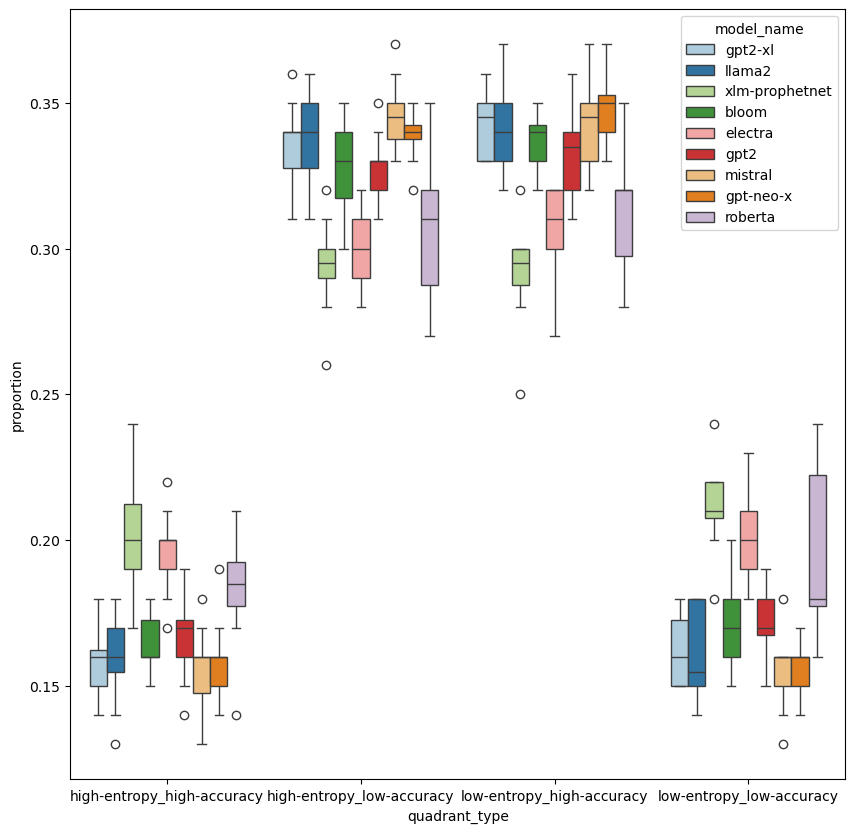

In [1535]:
fig, axes = plot_accuracy_by_group(all_tasks_quadrants, 
           iterate_col=None,
           x='quadrant_type', 
           y='proportion', 
           hue='model_name', 
           hue_order=grouped.index,
           figsize=10)

<Axes: xlabel='quadrant_type', ylabel='proportion'>

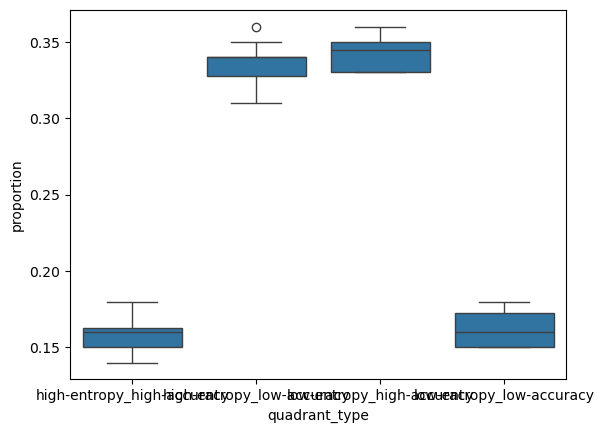

In [1460]:
sns.boxplot(all_tasks_quadrants, x='quadrant_type', y='proportion')

In [1408]:
x_len = np.unique(df_divide['entropy_group']).shape[0]
y_len = np.unique(df_divide['accuracy_group']).shape[0]

items = {'-'.join(labels): round(len(df)/len(df_divide), 2) for labels, df in df_divide.groupby([x_group, y_group])}


